In [1]:
import geopandas as gpd
import pandas as pd
import censusdata
import json
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from OpenCity import OpenCity

In [3]:
year=2018
state_fips='06'
# state_key='ca'
# centre=[-122.143936, 37.468319]
# radius=100000

In [4]:
ua=gpd.read_file('zip://../data/shape/tl_2017_us_uac10.zip')
print(ua.crs)
ua = ua.to_crs("EPSG:4326")
print(ua.crs)

epsg:4269
EPSG:4326


In [5]:
state=OpenCity.US_State(state_fips=state_fips, year=year)

In [272]:
try:
    bg_all=gpd.read_file('zip://../data/shape/cb_2019_{}_bg_500k.zip'.format(state_fips))
    bg_all = bg_all.to_crs("EPSG:4326").set_index('GEOID')
except:
    state.get_geometry()
    bg_all=state.geom

In [273]:
bg_all.head()

,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,AFFGEOID,NAME,LSAD,ALAND,AWATER,geometry
GEOID,,,,,,,,,,
060378004081,06,037,800408,1,1500000US060378004081,1,BG,2792751,1500447,"POLYGON ((-118.78754 34.02718, -118.78607 34.0..."
060411242004,06,041,124200,4,1500000US060411242004,4,BG,2259455,973726,"POLYGON ((-122.48698 37.89918, -122.48416 37.9..."
060590626194,06,059,062619,4,1500000US060590626194,4,BG,369794,343273,"POLYGON ((-117.77753 33.53639, -117.77558 33.5..."
060510001011,06,051,000101,1,1500000US060510001011,1,BG,2978150540,1148631,"POLYGON ((-118.94597 37.77522, -118.94348 37.7..."
060930002001,06,093,000200,1,1500000US060930002001,1,BG,1300052761,72751421,"POLYGON ((-122.25174 41.75805, -122.24754 41.7..."


# 15-minute communities

All metrics are calculated over the area inside a 15-minute accessible isochrone from the place of interest. For example, the metrics for block group X will be based on the community which is accessible within 15 minutes from the centroid of block group X. The mode of accessibility will generally be walking but for some metrics (eg. hospital access), driving accessibility will be used. <br>

The 15-minute communities for each block-group are computed in a pre-processing stage of the analysis. For walking accessibility, a network distance of 1200m is used as the limit (based on 4.8km/hr walkng speed). For each block-group, the following steps are carried out: <br>

- Identify the block-groups which are within 1200m straight line distance
- Of this subset, get the walking distance on the network to each block_group using the OSRM routing API. 
The results are saved as a json file where the keys are block-group IDs and the values are lists of accessible block-groups. <br>

# Compute example metrics over walkable community


# Spatial

## Density
$D_x = N_x/A $
#### Employment Density
The number of jobs divided by land area

#### Residential Density
The number of residents divided by land area

## Proximity

#### Walkable Access to Jobs
The number of jobs in the local community, normalised by population

#### Walkable Access to Healthcare
The number of people employed in the healthcare industry in the local community, normalised by population

#### Walkable Access to hospitality
The number of people employed in the hospitality industry in the local community, normalised by population

#### Walkable Access to shopping
The number of people employed in the retail industry in the local community, normalised by population

## Diversity
### Shannon Equitability Score
$ E_H = \Large\frac{-\sum_{j=1}^S{p_jlnp_j}}{ln(S)} $
#### Industry Diversity
Shannon Equitability Score for industries located in local community (by 2-digit NAICS codes)

#### Occupation Diversity
Shannon Equitability Score for occupations located in local community (by 2-digit NAICS codes)

#### Income Diversity
Shannon Equitability Score for income of residents of the local community

#### Education Diversity
Shannon Equitability Score for educational achievement of residents of the local community

# Social Performance
#### Live-Work Balance Score
The symmetry between number of accessible jobs and local population size: <br>
$ LW = \Large\frac{min(n_{jobs}, n_{pop})}{max(n_{jobs}, n_{pop})} $

#### Live-Work Income Harmony
The symmetry in income level between workers and residents in a community. Computed as cosine simmilarity between vector of residential income categories and employed income categories<br>
$ IH = \Large\frac{I_w  \cdot I_h} {|I_w| \quad \times \quad |I_h|} $

#### Live-Work Eduction Harmony
The symmetry in education level between workers and residents in a community. Computed as cosine simmilarity between vector of residential education categories and employed education categories<br>
$ EH = \Large\frac{E_w \cdot E_h} {|E_w|  \quad \times \quad |E_h|} $

#### Housing Ownership Rate
The percentage of owner-occupied housing units

#### Labour Participation Rate
The percentage of people in the work force

#### Employment Rate
The percentage of the labour force who are employed

### Subset zones by urban areas

<AxesSubplot:>

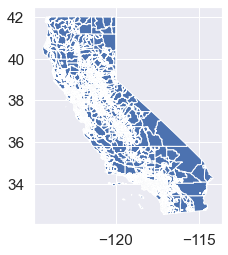

In [274]:
bg_all.plot()

<AxesSubplot:>

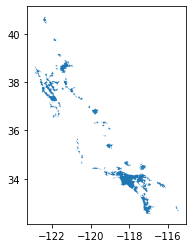

In [9]:
ua_state=ua.loc[ua['NAMELSAD10'].str.contains(' {}'.format(state.state.abbr))]
urbanized_state=ua_state.loc[ua_state['UATYP10']=='U']
urbanized_state.plot()

<AxesSubplot:>

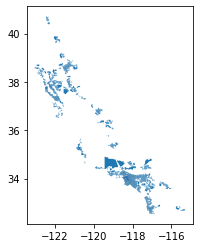

In [10]:
bg_all['GEOID']=bg_all.index
bg_intersect_ua=gpd.overlay(bg_all, urbanized_state, how='intersection')
bg=bg_all.loc[bg_intersect_ua['GEOID'].unique()]
bg.plot()

### Load json file which maps BGs to walkable BGs

In [11]:
bg_to_walkable_bg=json.load(open('../outputs/{}/bg_to_walkable_bg_osrm_{}.json'.format(
    state_fips, state_fips)))

### Load the census data

In [294]:
tenure=pd.read_csv('../data/census/{}/tenure/ACSDT5Y2019.B25008_data_with_overlays_2021-02-03T061524.csv'.format(state_fips), skiprows=1)
tenure['GEOID']=tenure.apply(lambda row: row['id'].split('US')[1], axis=1)
tenure=tenure.set_index('GEOID').rename(columns={
    'Estimate!!Total:': 'tenure_all', 'Estimate!!Total:!!Owner occupied': 'tenure_owned' })

In [314]:
labour=pd.read_csv('../data/census/{}/labour_force/ACSDT5Y2019.B23025_data_with_overlays_2021-02-03T060306.csv'.format(state_fips), skiprows=1)
labour['GEOID']=labour.apply(lambda row: row['id'].split('US')[1], axis=1)
labour=labour.set_index('GEOID').rename(columns={
    'Estimate!!Total:': 'labour_all',
    'Estimate!!Total:!!In labor force:': 'in_labour_force', 
    'Estimate!!Total:!!In labor force:!!Civilian labor force:!!Unemployed': 'unemployed' })

### Get and clean IO Skills data

Copied from https://github.com/CityScope/CS_Urban_Indicators/blob/master/indicator_tools.py

In [17]:
occ_level=5
naics_level=2

IO_dataRaw=pd.read_excel('../data/oesm18in4/nat4d_M2018_dl.xlsx')
IO_data = IO_dataRaw[(IO_dataRaw['OCC_GROUP']=='detailed')&(IO_dataRaw['TOT_EMP']!='**')]
IO_data = IO_data.astype({'TOT_EMP': 'float'})
IO_data = IO_data.assign(NAICS=('00'+IO_data['NAICS'].astype(str)).str[-6:])
IO_data = IO_data.assign(SELECTED_LEVEL=IO_data['OCC_CODE'].str[:occ_level])
IO_data = IO_data.groupby(['NAICS','SELECTED_LEVEL']).sum()[['TOT_EMP']].reset_index()
IO_data.head()

,NAICS,SELECTED_LEVEL,TOT_EMP
0,113300,11-10,520.0
1,113300,11-30,60.0
2,113300,11-91,100.0
3,113300,13-10,140.0
4,113300,13-11,60.0


In [18]:
empOccRaw = pd.read_excel('../data/oesm18nat/national_M2018_dl.xlsx')
empOcc = empOccRaw[empOccRaw['OCC_GROUP']=='detailed']
empOcc = empOcc[['OCC_CODE','TOT_EMP','OCC_GROUP']]
empOcc['SELECTED_LEVEL'] = empOcc['OCC_CODE'].str[:occ_level]
empOcc.head()

,OCC_CODE,TOT_EMP,OCC_GROUP,SELECTED_LEVEL
4,11-1011,195530,detailed,11-10
6,11-1021,2289770,detailed,11-10
8,11-1031,50330,detailed,11-10
11,11-2011,25260,detailed,11-20
13,11-2021,240440,detailed,11-20


In [19]:
onet_url = 'https://www.onetcenter.org/dl_files/database/db_24_2_excel/'
skillsRaw = pd.read_excel(onet_url+'Skills.xlsx')

skills = skillsRaw[['O*NET-SOC Code','Element ID','Element Name','Data Value','Recommend Suppress','Not Relevant']]
skills = skills[(skills['Not Relevant']!='Yes')&(skills['Recommend Suppress']!='Y')]
skills['SELECTED_LEVEL'] = skills['O*NET-SOC Code'].str[:occ_level]
skills['OCC_CODE'] = skills['O*NET-SOC Code'].str[:7]
skills = pd.merge(skills,empOcc[['OCC_CODE','TOT_EMP']])
skills = pd.merge(skills,empOcc.groupby('SELECTED_LEVEL').sum()[['TOT_EMP']].reset_index().rename(columns={'TOT_EMP':'TOT_EMP_3'}))
skills['w'] = skills['TOT_EMP']/skills['TOT_EMP_3']
skills['Data Value'] = skills['Data Value']*skills['w']
skills = skills.groupby(['SELECTED_LEVEL','Element ID','Element Name']).sum()[['Data Value']].reset_index()
skills.head()

,SELECTED_LEVEL,Element ID,Element Name,Data Value
0,11-10,2.A.1.a,Reading Comprehension,8.436113
1,11-10,2.A.1.b,Active Listening,8.535224
2,11-10,2.A.1.c,Writing,7.721820
3,11-10,2.A.1.d,Speaking,8.574552
4,11-10,2.A.1.e,Mathematics,5.409294


In [26]:
def industry_to_occupation_comp(industry_composition):
    IO_data['SELECTED_NAICS'] = IO_data['NAICS'].str[:naics_level]

    worker_composition = IO_data.groupby(['SELECTED_NAICS','SELECTED_LEVEL']).sum()[['TOT_EMP']].reset_index()
    worker_composition = worker_composition.set_index(['SELECTED_NAICS','SELECTED_LEVEL'])/worker_composition.groupby('SELECTED_NAICS').sum()[['TOT_EMP']]
    worker_composition = worker_composition.reset_index()

    industry_composition_df = pd.DataFrame(industry_composition.items(),columns=['SELECTED_NAICS','number'])
    industry_composition_df['SELECTED_NAICS'] = ('000000'+industry_composition_df['SELECTED_NAICS'].astype(str)).str[-1*naics_level:]

    worker_composition = pd.merge(worker_composition,industry_composition_df)
    worker_composition['TOT_EMP'] = worker_composition['TOT_EMP']*worker_composition['number']
    worker_composition = worker_composition.groupby('SELECTED_LEVEL').sum()[['TOT_EMP']].reset_index()
    worker_composition = dict(worker_composition.values)
    return worker_composition

In [85]:
def occupation_to_skill_comp(worker_composition, normalise=False):
    totalWorkers = sum(worker_composition.values())
    nWorkers = pd.DataFrame(worker_composition.items(),columns=['SELECTED_LEVEL','N'])
    workers_by_skill = pd.merge(skills,nWorkers)
    workers_by_skill['Data Value'] = workers_by_skill['Data Value']*workers_by_skill['N']
    skill_composition = workers_by_skill.groupby('Element Name').sum()[['Data Value']].reset_index()
    # normalise by nworkers to get average value of each skill across workers
    if normalise:
        skill_composition['Data Value'] = skill_composition['Data Value']/nWorkers['N'].sum()
    skill_composition = dict(skill_composition.values)
    return skill_composition

In [86]:
industry_composition={'11': 4000, '21': 4000}
worker_composition=industry_to_occupation_comp(industry_composition)
print(sum([worker_composition[o] for o in worker_composition]))
skills_composition=occupation_to_skill_comp(worker_composition, normalise=True)
print(sum([skills_composition[o] for o in skills_composition]))
print(skills_composition)

8000.0
229.37960451941632
{'Active Learning': 7.801354721578138, 'Active Listening': 8.965977638933754, 'Complex Problem Solving': 7.93026862222607, 'Coordination': 8.750654110961815, 'Critical Thinking': 9.090771894136838, 'Equipment Maintenance': 5.627108990723164, 'Equipment Selection': 5.166564827355859, 'Installation': 2.340687728083268, 'Instructing': 7.111089179610594, 'Judgment and Decision Making': 8.210641782337614, 'Learning Strategies': 6.929975962663898, 'Management of Financial Resources': 4.163695730065633, 'Management of Material Resources': 4.730925055414111, 'Management of Personnel Resources': 7.179452925056023, 'Mathematics': 6.1968519760749805, 'Monitoring': 8.90817238943144, 'Negotiation': 6.65470425473261, 'Operation Monitoring': 7.6789029574760805, 'Operation and Control': 7.171124015270708, 'Operations Analysis': 3.985883473197305, 'Persuasion': 7.091472997967225, 'Programming': 2.429955277858053, 'Quality Control Analysis': 6.992362864181126, 'Reading Comprehe

### Get and clean the LODES Data

In [43]:
try:
    rac=pd.read_csv('../data/lodes/rac_{}_{}'.format(state_fips, year))
    rac['h_geoid']=rac.apply(lambda row: str(row['h_geoid']).zfill(12), axis=1)
    rac=rac.set_index('h_geoid')
    
    wac=pd.read_csv('../data/lodes/wac_{}_{}'.format(state_fips, year))
    wac['w_geoid']=wac.apply(lambda row: str(row['w_geoid']).zfill(12), axis=1)
    wac=wac.set_index('w_geoid')
except:
    state.get_lodes_data(include=['rac', 'wac'])
    rac=state.rac
    wac=state.wac
    wac.to_csv('../data/lodes/wac_{}_{}'.format(state_fips, year))
    rac.to_csv('../data/lodes/rac_{}_{}'.format(state_fips, year))

In [ ]:
# try:
#     od=pd.read_csv('../data/lodes/od_{}_{}'.format(state_fips, year))
#     od['h_geoid']=od.apply(lambda row: str(row['h_geoid']).zfill(12), axis=1)
#     od['w_geoid']=od.apply(lambda row: str(row['w_geoid']).zfill(12), axis=1)
#     od=od.set_index(['h_geoid', 'w_geoid'])
# except:
#     state.get_lodes_data(include=['od'])
#     od=state.od
#     od.to_csv('../data/lodes/od_{}_{}'.format(state_fips, year))

#### Both files:
- CA: age groups
- CE: earnings groups
- CNS: NAICS
- CR: race
- CT: ethnicity
- CD: education
- CS: sex
#### Additional in WAC:
- CFA: firm age
- CFA: firm size

In [44]:
all_bg_in_rac=set(rac.index)
all_bg_in_wac=set(wac.index)

### Functions to compute metrics for a single GEOID

#### Basic Statistics

In [45]:
def get_residents_columns_rac(bgs_in_community, full_rac, all_bg_in_rac):
    """
    returns a subset of the OD matrix
    The subset includes all rows corresponding to origins within the community
    i.e. all residents of the community
    """
    output_dict={}
    bgs_in_rac=[bg for bg in bgs_in_community if bg in all_bg_in_rac]
    if len(bgs_in_rac)>0:
        rac_subset=full_rac.loc[bgs_in_rac]
        sum_rac=rac_subset.sum()
        output_dict['total_pop_rac']=sum_rac['C000']
        output_dict['res_income_u1250_rac']=sum_rac['CE01']
        output_dict['res_income_1251-3333_rac']=sum_rac['CE02']
        output_dict['res_income_3333+_rac']=sum_rac['CE03']
        output_dict['res_age_u29_rac']=sum_rac['CE01']
        output_dict['res_age_30-54_rac']=sum_rac['CE02']
        output_dict['res_age_55+_rac']=sum_rac['CE03']
        output_dict['res_edu_no_highsch']=sum_rac['CD01']
        output_dict['res_edu_highsch']=sum_rac['CD02']
        output_dict['res_edu_some_college']=sum_rac['CD03']
        output_dict['res_edu_bach_or_higher']=sum_rac['CD04']
    else:
        print('No data for this community in RAC file: {}'.format(bgs_in_community))
    return output_dict


In [46]:
def get_workers_columns_wac(bgs_in_community, full_wac, all_bg_in_wac):
    """
    returns a subset of the OD matrix
    The subset includes all rows corresponding to origins within the community
    i.e. all residents of the community
    """
    output_dict={}
    bgs_in_wac=[bg for bg in bgs_in_community if bg in all_bg_in_wac]
    if len(bgs_in_wac)>0:
        wac_subset=full_wac.loc[bgs_in_wac]
        sum_wac=wac_subset.sum()
        output_dict['total_employ_wac']=sum_wac['C000']
        output_dict['emp_income_u1250_wac']=sum_wac['CE01']
        output_dict['emp_income_1251-3333_wac']=sum_wac['CE02']
        output_dict['emp_income_3333+_wac']=sum_wac['CE03']
        output_dict['emp_age_u29_wac']=sum_wac['CE01']
        output_dict['emp_age_30-54_wac']=sum_wac['CE02']
        output_dict['emp_age_55+_wac']=sum_wac['CE03']
        output_dict['emp_edu_no_highsch']=sum_wac['CD01']
        output_dict['emp_edu_highsch']=sum_wac['CD02']
        output_dict['emp_edu_some_college']=sum_wac['CD03']
        output_dict['emp_edu_bach_or_higher']=sum_wac['CD04']
        output_dict['emp_naics_11']=sum_wac['CNS01']
        output_dict['emp_naics_21']=sum_wac['CNS02']
        output_dict['emp_naics_22']=sum_wac['CNS03']
        output_dict['emp_naics_23']=sum_wac['CNS04']
        output_dict['emp_naics_31-33']=sum_wac['CNS05']
        output_dict['emp_naics_42']=sum_wac['CNS06']
        output_dict['emp_naics_44-45']=sum_wac['CNS07']
        output_dict['emp_naics_48-49']=sum_wac['CNS08']
        output_dict['emp_naics_51']=sum_wac['CNS09']
        output_dict['emp_naics_52']=sum_wac['CNS10']
        output_dict['emp_naics_53']=sum_wac['CNS11']
        output_dict['emp_naics_54']=sum_wac['CNS12']
        output_dict['emp_naics_55']=sum_wac['CNS13']
        output_dict['emp_naics_56']=sum_wac['CNS14']
        output_dict['emp_naics_61']=sum_wac['CNS15']
        output_dict['emp_naics_62']=sum_wac['CNS16']
        output_dict['emp_naics_71']=sum_wac['CNS17']
        output_dict['emp_naics_72']=sum_wac['CNS18']
        output_dict['emp_naics_81']=sum_wac['CNS19']
        output_dict['emp_naics_92']=sum_wac['CNS20']
        output_dict['emp_prv_firm_size_u19']=sum_wac['CFS01']
        output_dict['emp_prv_firm_size_20-49']=sum_wac['CFS02']
        output_dict['emp_prv_firm_size_50-249']=sum_wac['CFS03']
        output_dict['emp_prv_firm_size_250-499']=sum_wac['CFS04']
        output_dict['emp_prv_firm_size_500+']=sum_wac['CFS05']
        output_dict['emp_prv_firm_age_0-1']=sum_wac['CFA01']
        output_dict['emp_prv_firm_age_2-3']=sum_wac['CFA02']
        output_dict['emp_prv_firm_age_4-5']=sum_wac['CFA03']
        output_dict['emp_prv_firm_age_6-10']=sum_wac['CFA04']
        output_dict['emp_prv_firm_age_11+']=sum_wac['CFA05']
    else:
        print('No data for this community in WAC file: {}'.format(bgs_in_community))
    return output_dict

In [47]:
def get_live_and_work_columns(bgs_in_community, od_by_hbg_wbg, all_bg_in_rac):
    output_dict={}
    bgs_in_od=[bg for bg in bgs_in_community if bg in all_bg_in_wac]
    if len(bgs_in_od)>0:
        live_community=od_by_hbg_wbg.loc[bgs_in_od]
        live_work_community=live_community.loc[live_community['w_block_group'].isin(bgs_in_community)]
        sum_live_work_community=live_work_community.sum()
        output_dict['total_live_and_work_od']=sum_live_work_community['S000']
    else:
        print('No data for this community in OD file: {}'.format(bgs_in_community))
    return output_dict  

In [48]:
def get_lodes_stats(row):
    geoid=row['GEOID']
    bgs_in_community=bg_to_walkable_bg[geoid]
#     print('{}: {}'.format(geoid, bgs_in_community))
    wac_outputs=get_workers_columns_wac(bgs_in_community, full_wac=wac, all_bg_in_wac=all_bg_in_wac)
    rac_outputs=get_residents_columns_rac(bgs_in_community, full_rac=rac, all_bg_in_rac=all_bg_in_rac)
#     od_outputs=get_live_and_work_columns(bgs_in_community, od_by_hbg_wbg, all_bg_in_rac=all_bg_in_rac)
    for var in rac_outputs:
        row[var]=rac_outputs[var]
    for var in wac_outputs:
        row[var]=wac_outputs[var]
#     for var in od_outputs:
#         row[var]=od_outputs[var]
    return row

In [275]:
def get_area_community(row):
    geoid=row['GEOID']
    bgs_in_community=bg_to_walkable_bg[geoid]
    area = bg_all.loc[bgs_in_community, 'ALAND'].sum()
    return area

In [49]:
bg=bg.apply(lambda row: get_lodes_stats(row), axis=1)

No data for this community in RAC file: ['060375736014']
No data for this community in WAC file: ['060374002074']
No data for this community in WAC file: ['060371370002']
No data for this community in RAC file: ['060371370002']
No data for this community in RAC file: ['060014090004']
No data for this community in RAC file: ['060816117004']
No data for this community in WAC file: ['060855116082']
No data for this community in RAC file: ['060855045042']
No data for this community in WAC file: ['060952528015']
No data for this community in WAC file: ['060952528013', '060952528012']
No data for this community in WAC file: ['060952528012', '060952528011']
No data for this community in RAC file: ['060952528012', '060952528011']
No data for this community in WAC file: ['060530141043', '060530141042']
No data for this community in RAC file: ['060530141043', '060530141042']
No data for this community in WAC file: ['060830029222']
No data for this community in RAC file: ['060014511014']


In [276]:
bg['comm_area']=bg.apply(lambda row: get_area_community(row), axis=1)

In [277]:
bg['res_density']=bg.apply(lambda row: row['total_pop_rac']/row['comm_area'], axis=1)
bg['emp_density']=bg.apply(lambda row: row['total_employ_wac']/row['comm_area'], axis=1)

Text(0.5, 1.0, 'res_density')

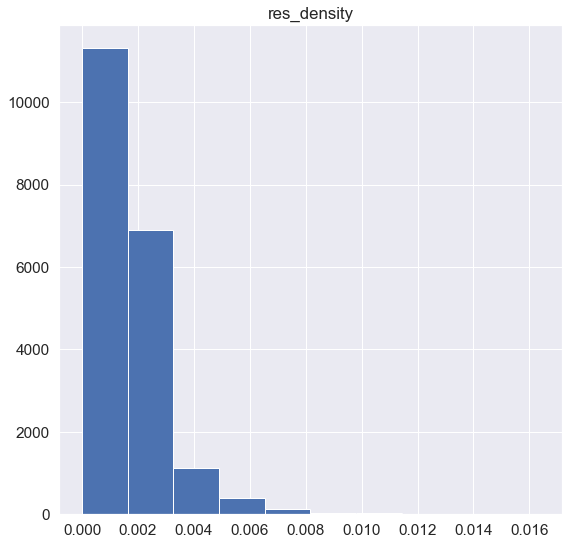

In [279]:
plt.figure(figsize=(9,9))
_=plt.hist(bg['res_density'])
plt.title('res_density')

<AxesSubplot:>

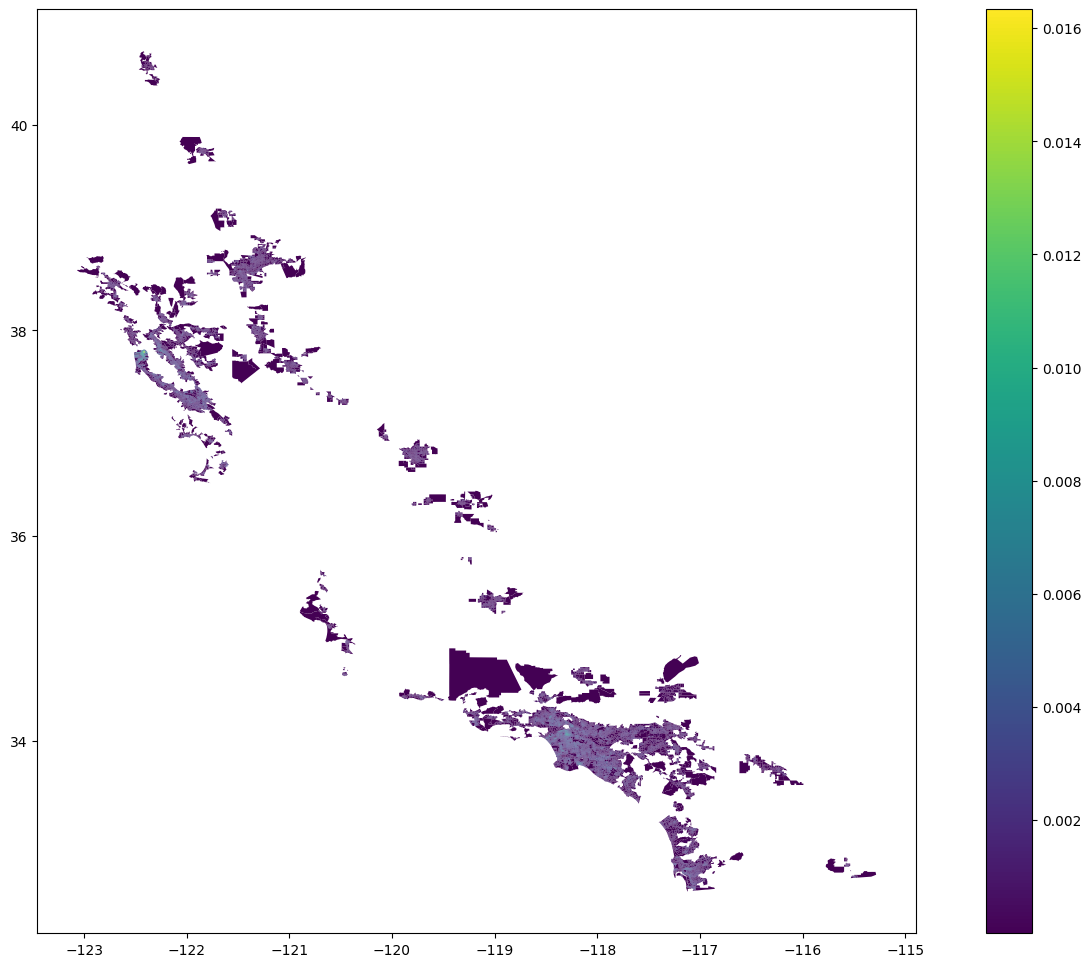

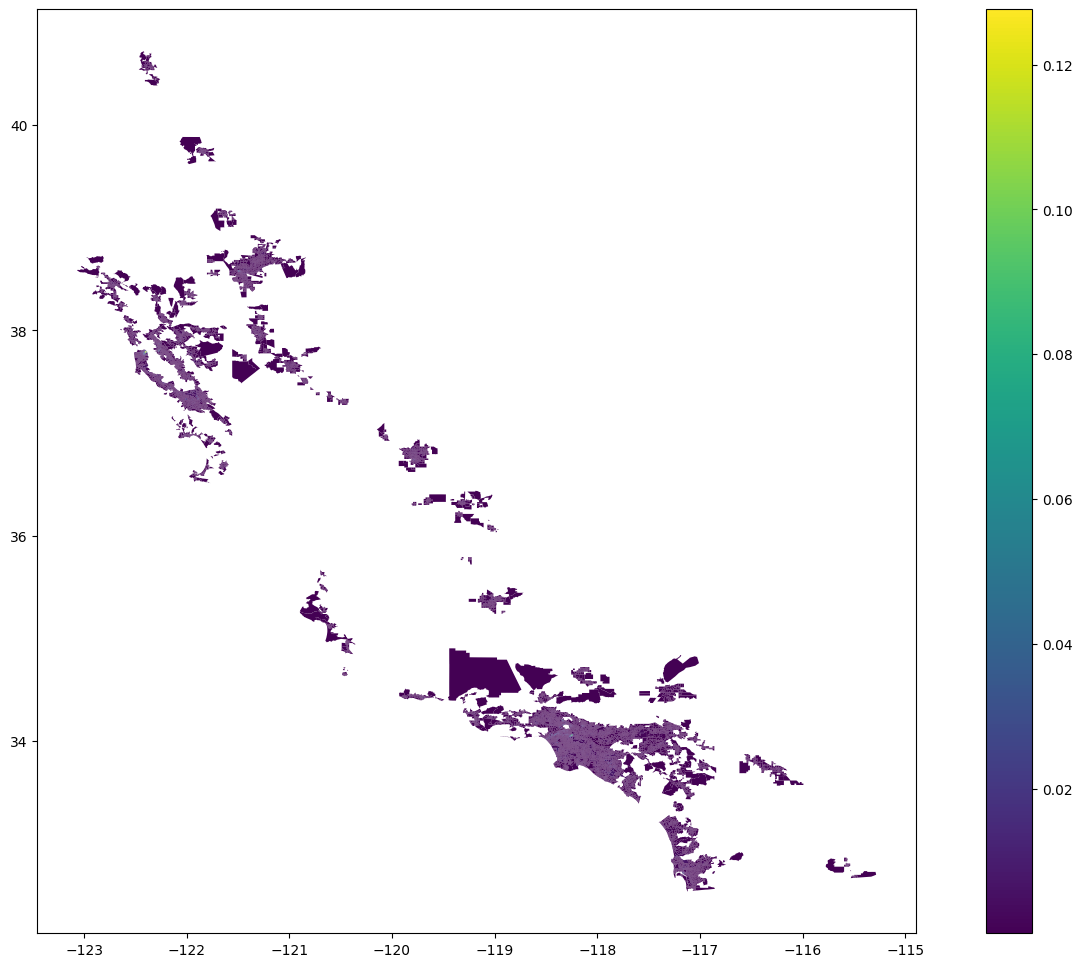

In [282]:
sns.reset_defaults()
fig, ax=plt.subplots(1, figsize=(18,12))
bg.plot(ax=ax,
        column='res_density',
        legend=True)

fig, ax=plt.subplots(1, figsize=(18,12))
bg.plot(ax=ax,
        column='emp_density',
        legend=True)

In [50]:
bg.head()

,AFFGEOID,ALAND,AWATER,BLKGRPCE,COUNTYFP,GEOID,LSAD,NAME,STATEFP,TRACTCE,...,res_age_u29_rac,res_edu_bach_or_higher,res_edu_highsch,res_edu_no_highsch,res_edu_some_college,res_income_1251-3333_rac,res_income_3333+_rac,res_income_u1250_rac,total_employ_wac,total_pop_rac
GEOID,,,,,,,,,,,,,,,,,,,,,
060378004081,1500000US060378004081,2792751,1500447,1,037,060378004081,BG,1,06,800408,...,101.0,100.0,35.0,31.0,93.0,61.0,153.0,101.0,398.0,315.0
060590014012,1500000US060590014012,328653,0,2,059,060590014012,BG,2,06,001401,...,319.0,364.0,303.0,293.0,425.0,618.0,848.0,319.0,834.0,1785.0
060372920001,1500000US060372920001,220344,0,1,037,060372920001,BG,1,06,292000,...,751.0,843.0,600.0,639.0,844.0,1367.0,1636.0,751.0,362.0,3754.0
060375702023,1500000US060375702023,288764,0,3,037,060375702023,BG,3,06,570202,...,619.0,461.0,497.0,583.0,610.0,1149.0,1117.0,619.0,490.0,2885.0
060374308013,1500000US060374308013,140077,0,3,037,060374308013,BG,3,06,430801,...,519.0,912.0,377.0,368.0,581.0,804.0,1343.0,519.0,6185.0,2666.0


TODO: at community level

### Join Census Variables

In [317]:
# bg=bg.join(tenure[['tenure_owned', 'tenure_all']], how='left')
bg=bg.join(labour[['labour_all','in_labour_force', 'unemployed']], how='left')

In [340]:
# plt.hist(bg['ALAND'], bins=[2e7*i for i in range(100)])
# sum(bg['ALAND']>0.5e8)/len(bg)

0.0023563621778802768

In [341]:
bg=bg.loc[bg['ALAND']<5e7]

In [342]:
bg.to_file('../outputs/{}/basic_stats_ua_{}/basic_stats_ua_{}.shp'.format(state_fips,state_fips, state_fips))

In [281]:
# bg=gpd.read_file('../outputs/{}/basic_stats_ua_{}/basic_stats_ua_{}.shp'.format(state_fips,state_fips, state_fips))
# bg=bg.set_index('GEOID')

### Live-Work Balance Score

In [52]:
def get_live_work_score(row):
    if row['total_pop_rac'] > row['total_employ_wac']:
        return row['total_employ_wac']/row['total_pop_rac']
    else:
        return row['total_pop_rac']/row['total_employ_wac']
    
# TODO- fix function to get live_work data before the below function
def get_live_work_jaccard_score(row):
    return None

In [53]:
bg['live_work_score']=bg.apply(lambda row: get_live_work_score(row), axis=1)

Text(0.5, 1.0, 'Live-Work Score')

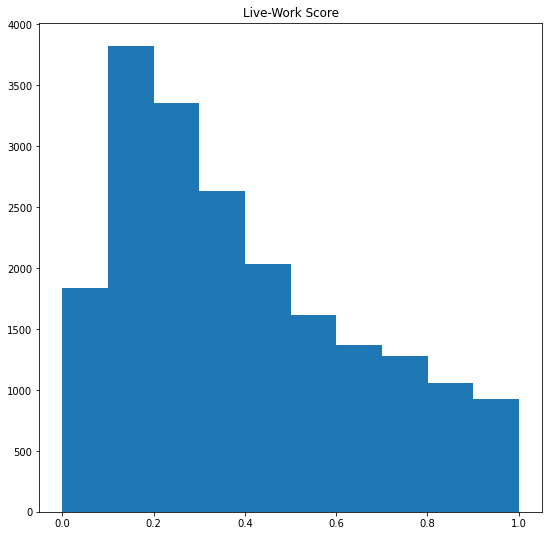

In [54]:
plt.figure(figsize=(9,9))
_=plt.hist(bg['live_work_score'])
plt.title('Live-Work Score')

<AxesSubplot:>

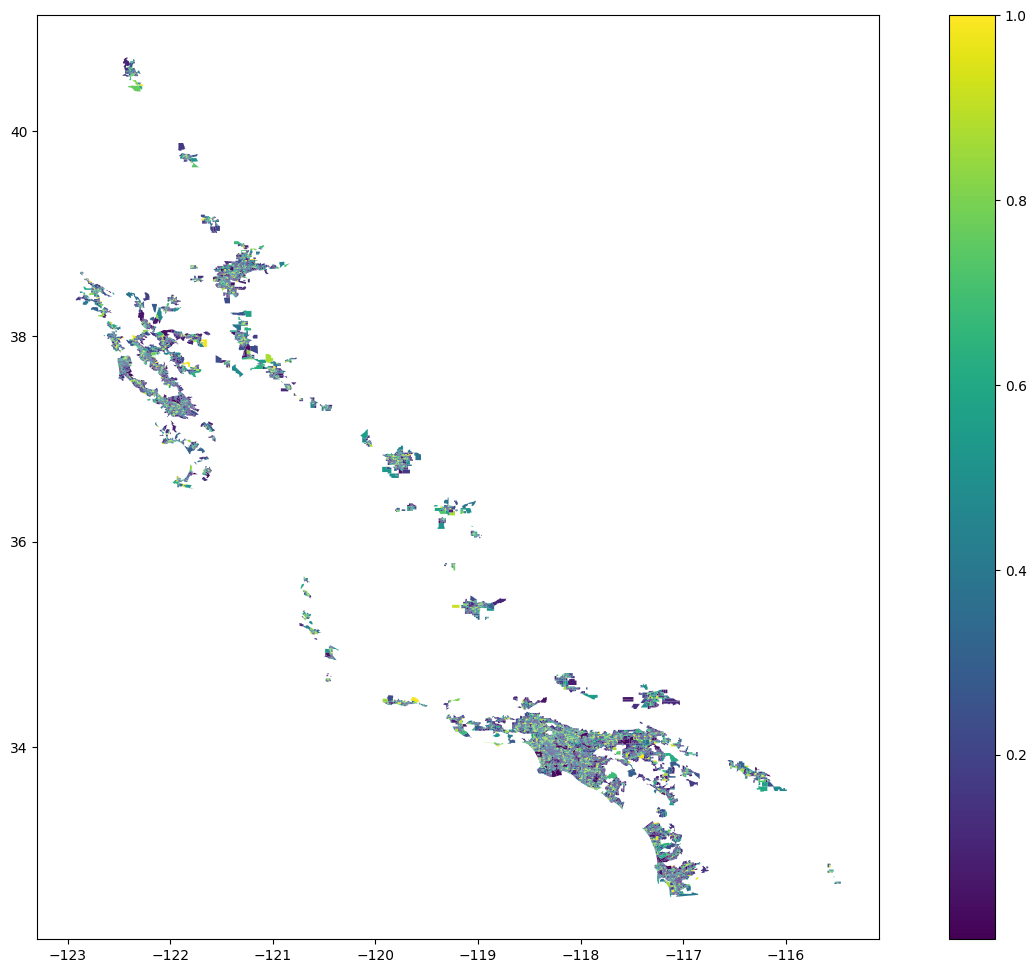

In [343]:
fig, ax=plt.subplots(1, figsize=(18,12))
bg.plot(ax=ax,
        column='live_work_score',
        legend=True)

### Demographic Harmony Scores

In [56]:
from numpy import dot
from numpy.linalg import norm

def get_income_harmony(row):
    res_income_vec=row.loc[['res_income_1251-3333_rac', 'res_income_3333+_rac', 'res_income_u1250_rac']]
    emp_income_vec=row.loc[['emp_income_1251-3333_wac', 'emp_income_3333+_wac', 'emp_income_u1250_wac']]
    a, b = res_income_vec.values, emp_income_vec.values
    return dot(a,b)/(norm(a)*norm(b))  

def get_edu_harmony(row):
    res_edu_vec=row[['res_edu_no_highsch', 'res_edu_highsch', 'res_edu_some_college', 'res_edu_bach_or_higher']]
    emp_edu_vec=row[['emp_edu_no_highsch', 'emp_edu_highsch', 'emp_edu_some_college', 'emp_edu_bach_or_higher']]
    a, b = res_edu_vec.values, emp_edu_vec.values
    return dot(a,b)/(norm(a)*norm(b)) 

In [57]:
bg['income_harmony']=bg.apply(lambda row: get_income_harmony(row), axis=1)
bg['edu_harmony']=bg.apply(lambda row: get_edu_harmony(row), axis=1)

<ipython-input-56-e59151ec7764>:14: RuntimeWarning: invalid value encountered in double_scalars
  return dot(a,b)/(norm(a)*norm(b))


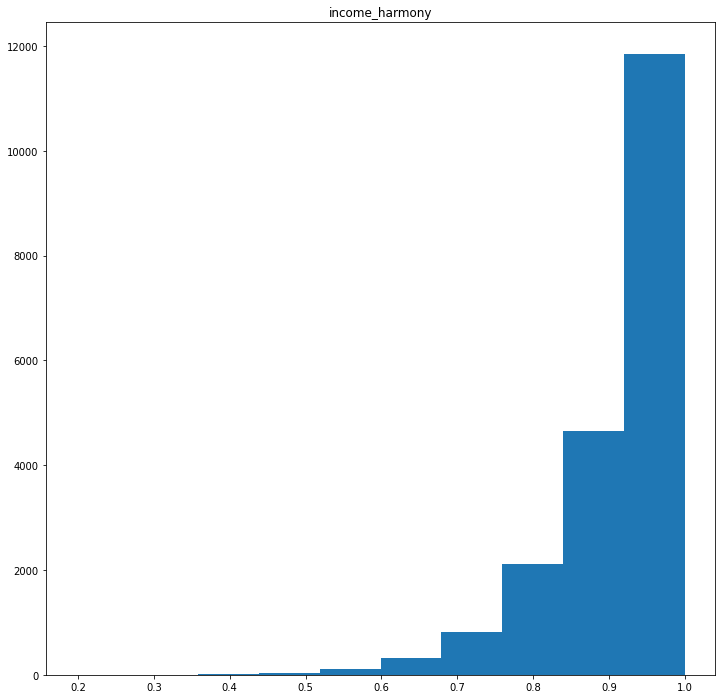

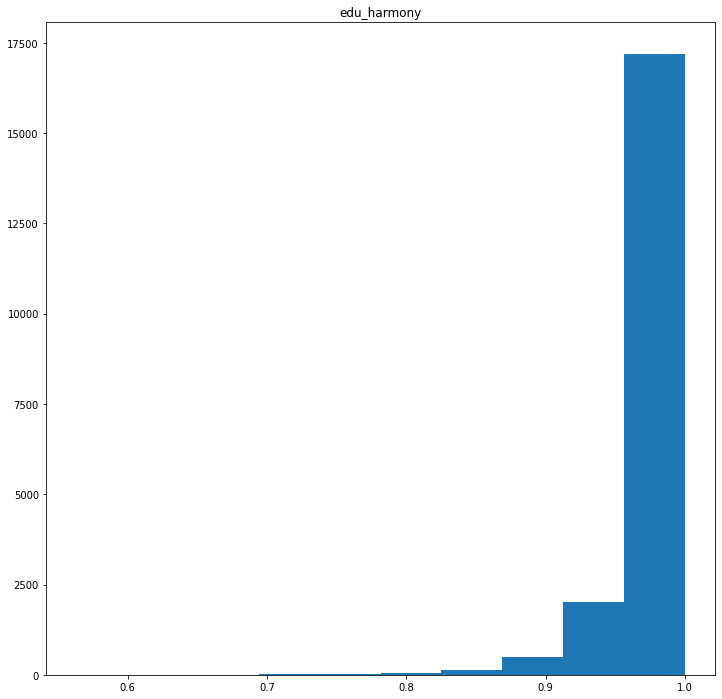

In [58]:
for col in ['income_harmony', 'edu_harmony']:
    plt.figure(figsize=(12,12))
    _=plt.hist(bg[col])
    plt.title(col)
    
#     fig, ax=plt.subplots(1, figsize=(18,12))
#     bg.plot(ax=ax,
#             column=col,
#             legend=True)
#     ax.set_title(col)

### Access to Amenities Scores

In [59]:
def get_access_scores(row):
    output_dict={}
    row['healthcare_access']=row['emp_naics_62']/row['total_pop_rac']
    row['hospitality_access']=row['emp_naics_72']/row['total_pop_rac']
    row['shopping_access']=row['emp_naics_44-45']/row['total_pop_rac']
    row['jobs_access']=row['total_employ_wac']/row['total_pop_rac']
    return row

In [60]:
bg=bg.apply(lambda row: get_access_scores(row), axis=1)

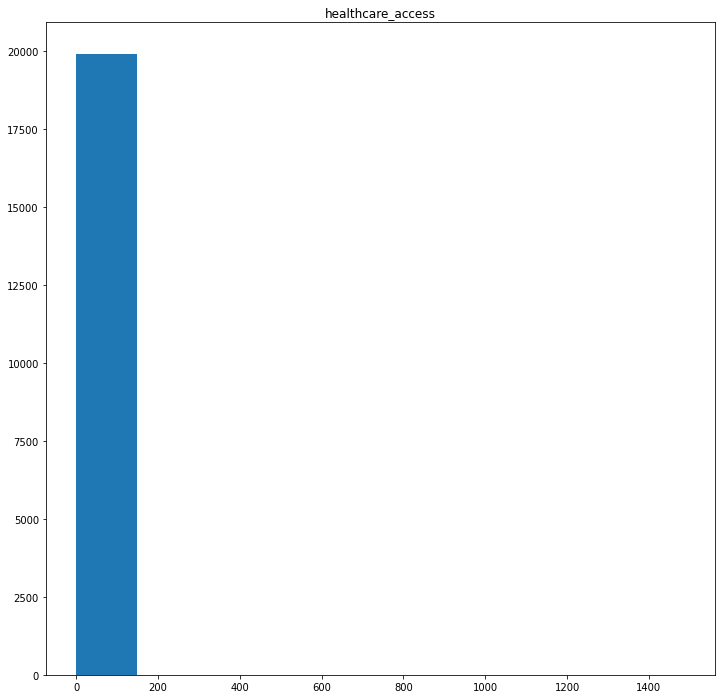

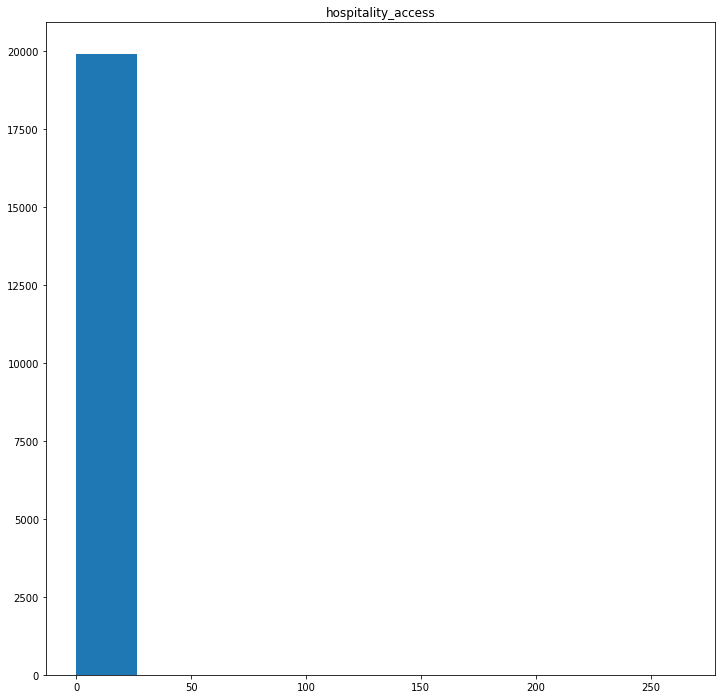

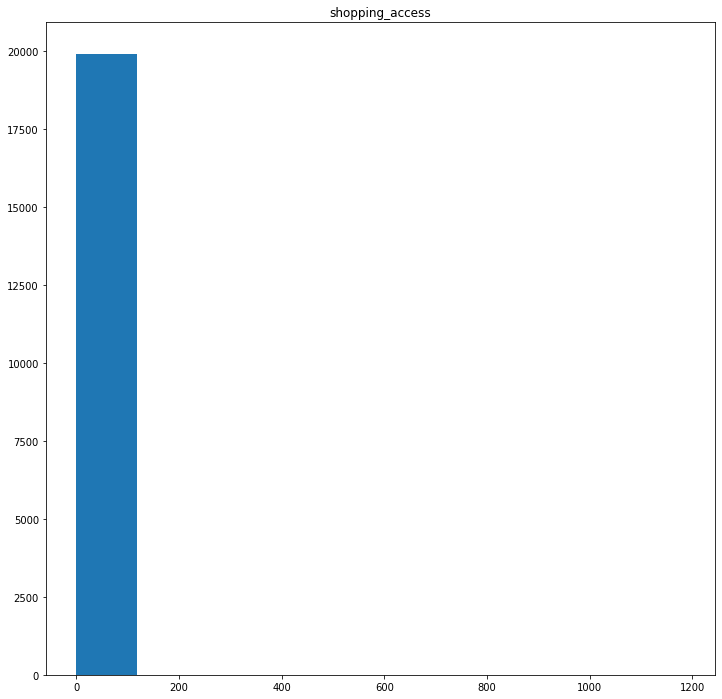

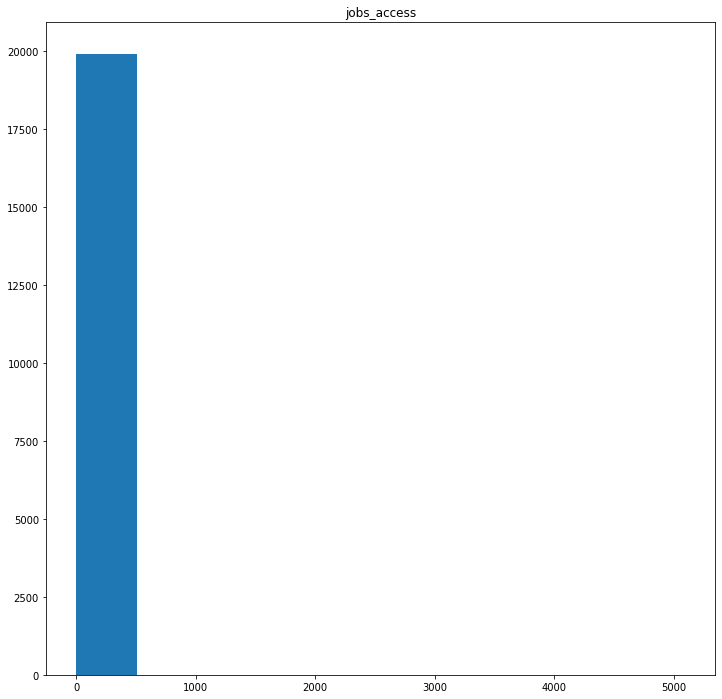

In [61]:
for col in ['healthcare_access', 'hospitality_access', 'shopping_access', 'jobs_access']:
    plt.figure(figsize=(12,12))
    _=plt.hist(bg[col])
    plt.title(col)
    
#     fig, ax=plt.subplots(1, figsize=(18,12))
#     bg.plot(ax=ax,
#             column=col,
#             legend=True)
#     ax.set_title(col)

### Skills Mix

In [191]:
def get_skills_mix(row):
    industry_composition={}
    for col in row.keys():
        if 'naics_' in col:
            naics_code=col.split('naics_')[1]
            industry_composition[naics_code]=row[col]
    worker_composition=industry_to_occupation_comp(industry_composition)
    skills_composition=occupation_to_skill_comp(worker_composition, normalise=True)
    row['worker_composition']=worker_composition
    row['skills_composition']=skills_composition
    return row

In [88]:
bg=bg.apply(lambda row: get_skills_mix(row), axis=1)

### Diversity Scores

In [213]:
import math
def shannon_equitability_score(species_counts):
    diversity=0
    pop_size=sum(species_counts)
    if ((len(species_counts)>1) and (pop_size>0)):        
        for count in species_counts:
            pj=count/pop_size
            if not pj==0:
                diversity+= -pj*math.log(pj)
        equitability=diversity/math.log(len(species_counts))
        return equitability
    else:
        return float('nan')
    
def get_diversity_scores(row):
    edu_group_cols=['res_edu_no_highsch', 'res_edu_highsch', 'res_edu_some_college', 'res_edu_bach_or_higher']
    income_group_cols=['res_income_1251-3333_rac', 'res_income_3333+_rac', 'res_income_u1250_rac']
    emp_group_cols=[col for col in row.keys() if 'emp_naics' in col]
    
    income_group_counts=[row[col] for col in income_group_cols]
    edu_group_counts=[row[col] for col in edu_group_cols]
    emp_group_counts=[row[col] for col in emp_group_cols]
    occ_counts=row['worker_composition'].values()
    
    row['income_diversity']=shannon_equitability_score(income_group_counts)
    row['education_diversity']=shannon_equitability_score(edu_group_counts)
    row['industry_diversity']=shannon_equitability_score(emp_group_counts)
    row['occupation_diversity']=shannon_equitability_score(occ_counts)
    return row
    

In [214]:
bg=bg.apply(lambda row: get_diversity_scores(row), axis=1)

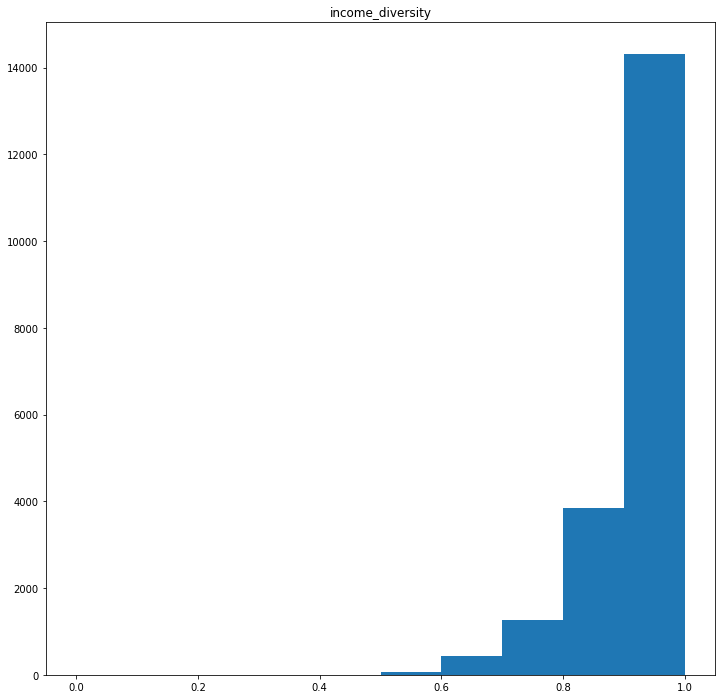

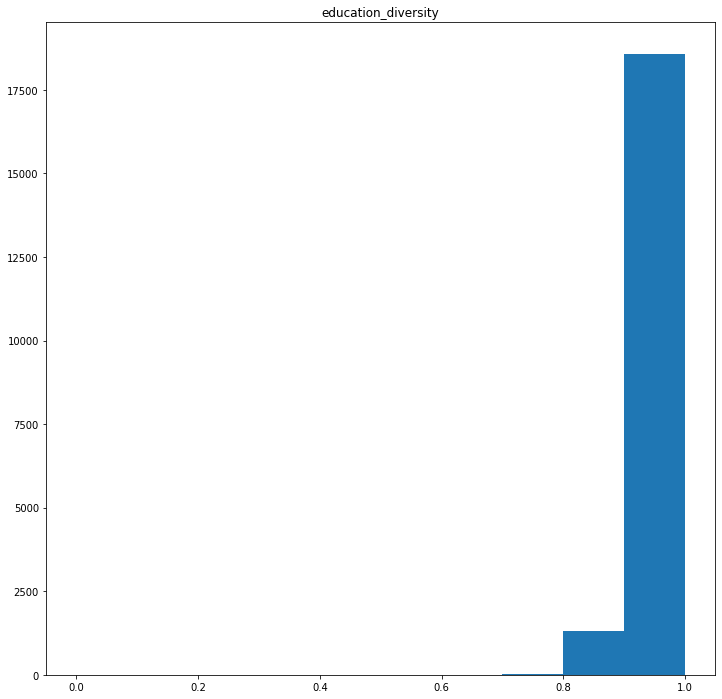

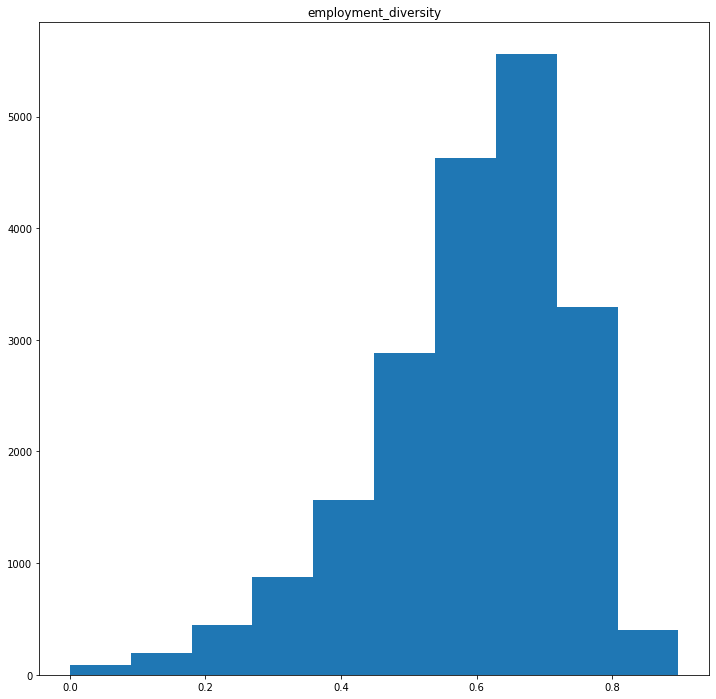

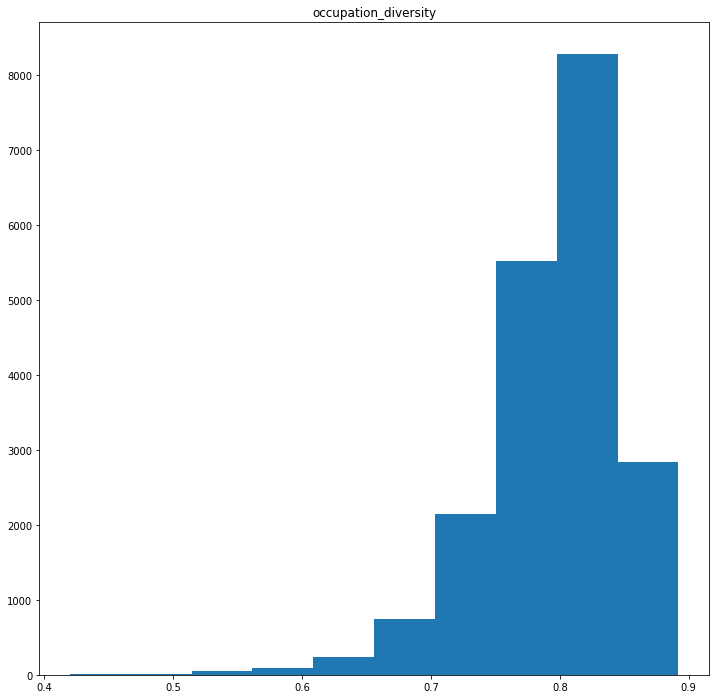

In [215]:
for col in ['income_diversity', 'education_diversity', 'industry_diversity', 'occupation_diversity']:
    plt.figure(figsize=(12,12))
    _=plt.hist(bg[col])
    plt.title(col)
    
#     fig, ax=plt.subplots(1, figsize=(18,12))
#     bg.plot(ax=ax,
#             column=col,
#             legend=True)
#     ax.set_title(col)


### ESG Scores

In [323]:
bg['housing_owned']=bg.apply(lambda row: 
                             row['tenure_owned']/row['tenure_all'] if row['tenure_all']>0 else 0, axis=1)
bg['labour_participation']=bg.apply(lambda row: 
                               (row['in_labour_force']/row['labour_all']) if row['labour_all']>0 else 0, axis=1)
bg['employment_rate']=bg.apply(lambda row: 
                               1- (row['unemployed']/row['in_labour_force']) if row['in_labour_force']>0 else 0, axis=1)

# Raw Indicators -> Percentiles

In [324]:
import numpy as np
import statsmodels
from statsmodels.distributions.empirical_distribution import ECDF

In [325]:
# score_groups={'Live-Work Symmetry':['live_work_score', 'income_harmony', 'edu_harmony'],
#               'Local Services': ['healthcare_access','hospitality_access', 'shopping_access'],
#               'Net-Zero Commuting': ['jobs_access'],
#               'Diversity': ['income_diversity', 'education_diversity', 'employment_diversity']}
              

In [330]:
all_raw_score_cols=['res_density', 'emp_density',
                    'jobs_access', 'hospitality_access', 'shopping_access', 'healthcare_access',
                    'education_diversity',  'income_diversity', 'industry_diversity', 'occupation_diversity',
                    'live_work_score', 'edu_harmony', 'income_harmony', 'housing_owned', 'labour_participation','employment_rate']

In [331]:
# all_raw_score_cols=set()
# for group in score_groups:
#     all_raw_score_cols.update(score_groups[group])
# print(all_raw_score_cols)
all_ecdf={}
for col in all_raw_score_cols:
    ecdf=ECDF(bg[col])
    all_ecdf[col]=ecdf
    bg[col+'_pct']=ecdf(bg[col])
    bg.loc[bg[col].isnull(), col+'_pct']=float('nan')
    
# for group in score_groups:
#     pct_cols_this_group=['{}_pct'.format(col) for col in score_groups[group]]
#     bg[group]=bg[pct_cols_this_group].mean(axis=1)

# Final Individual Scores

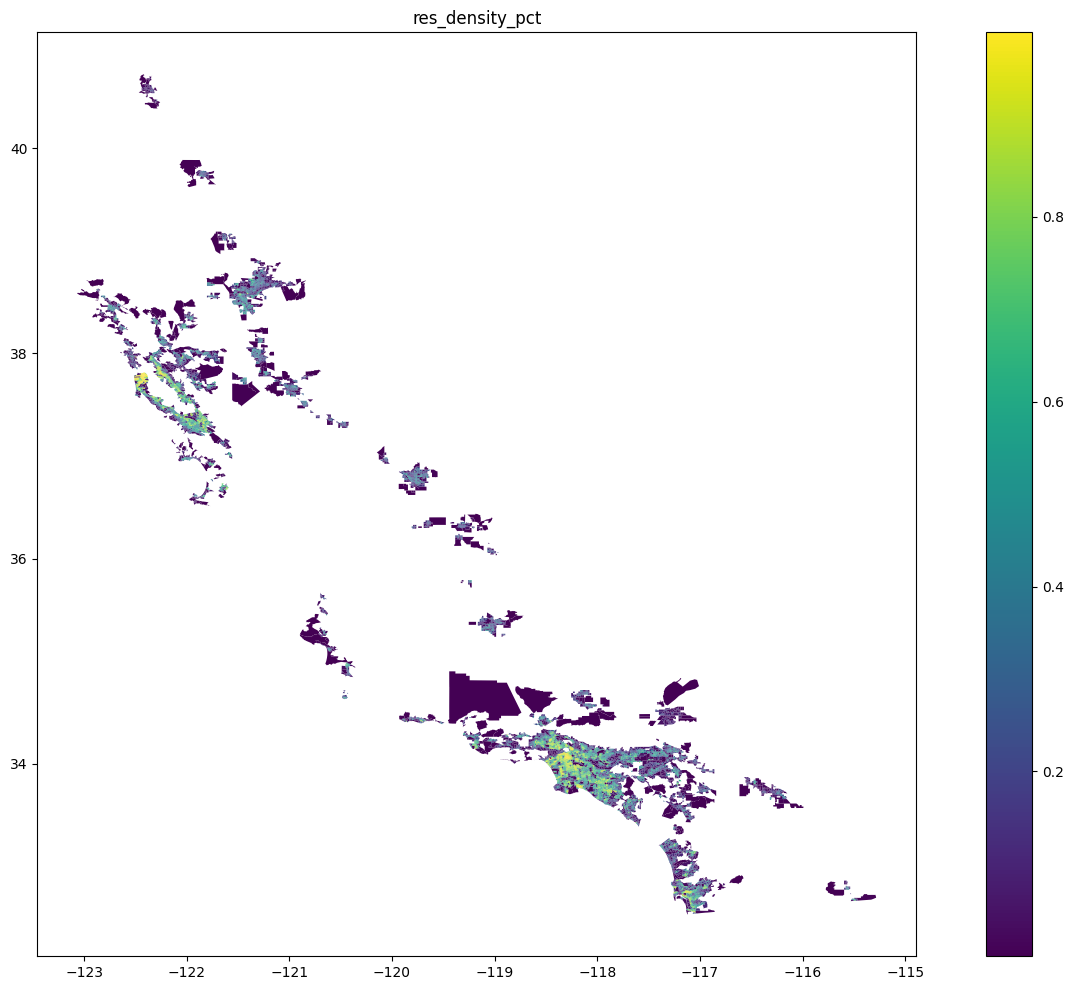

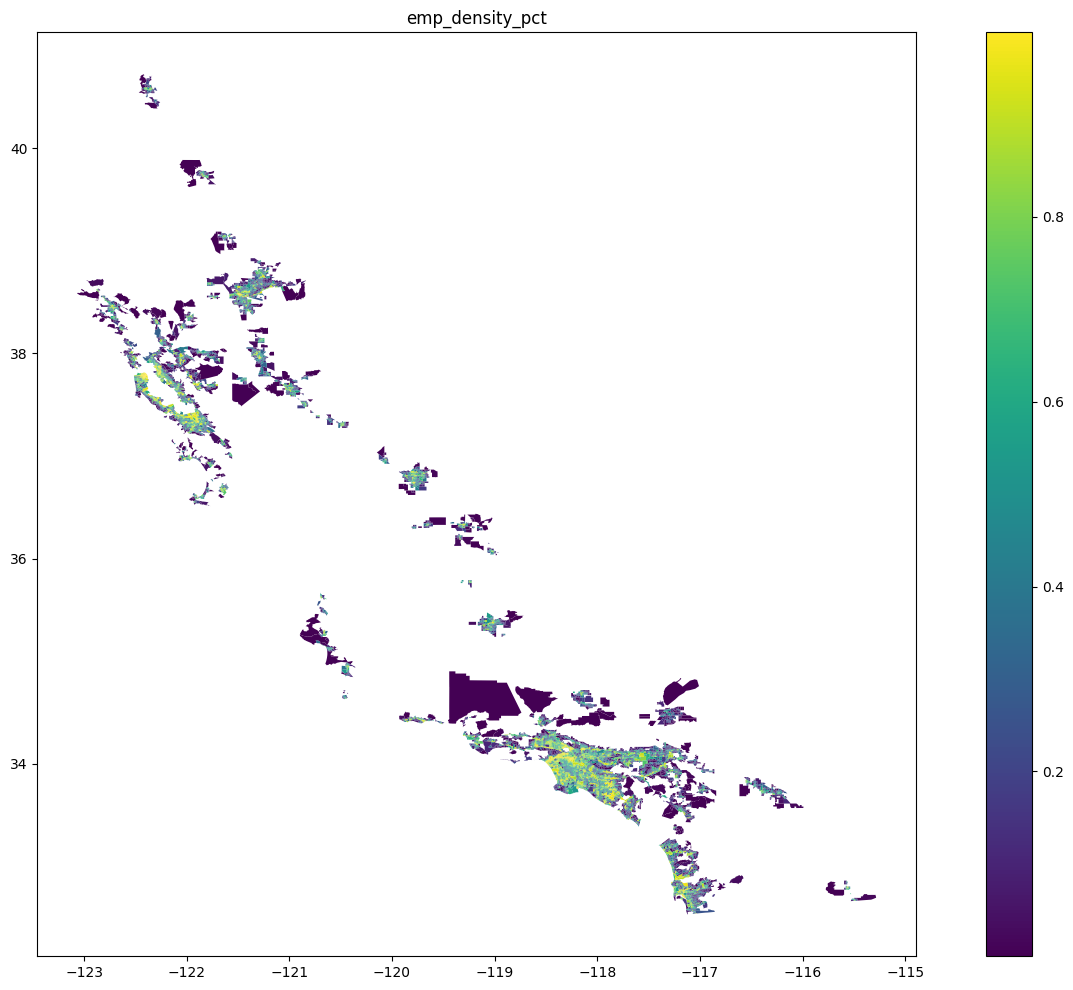

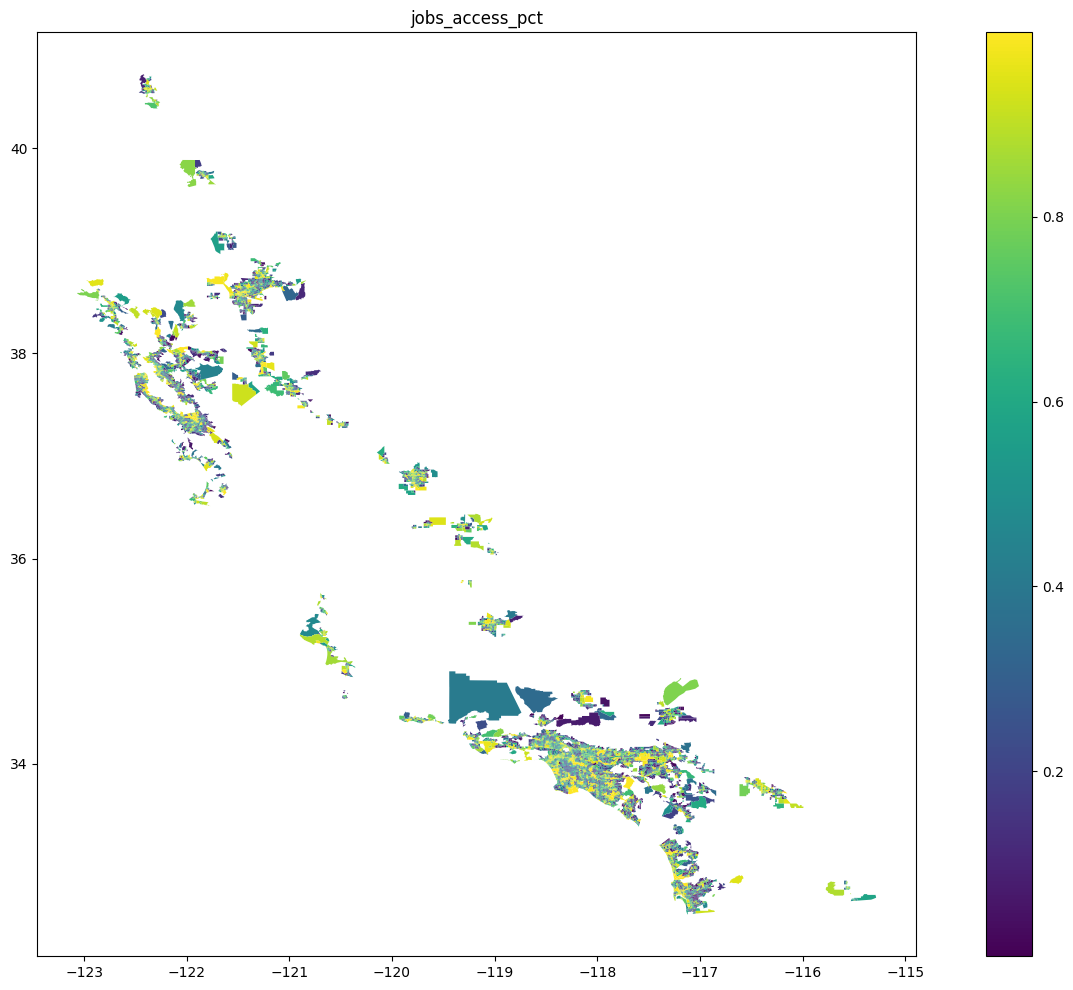

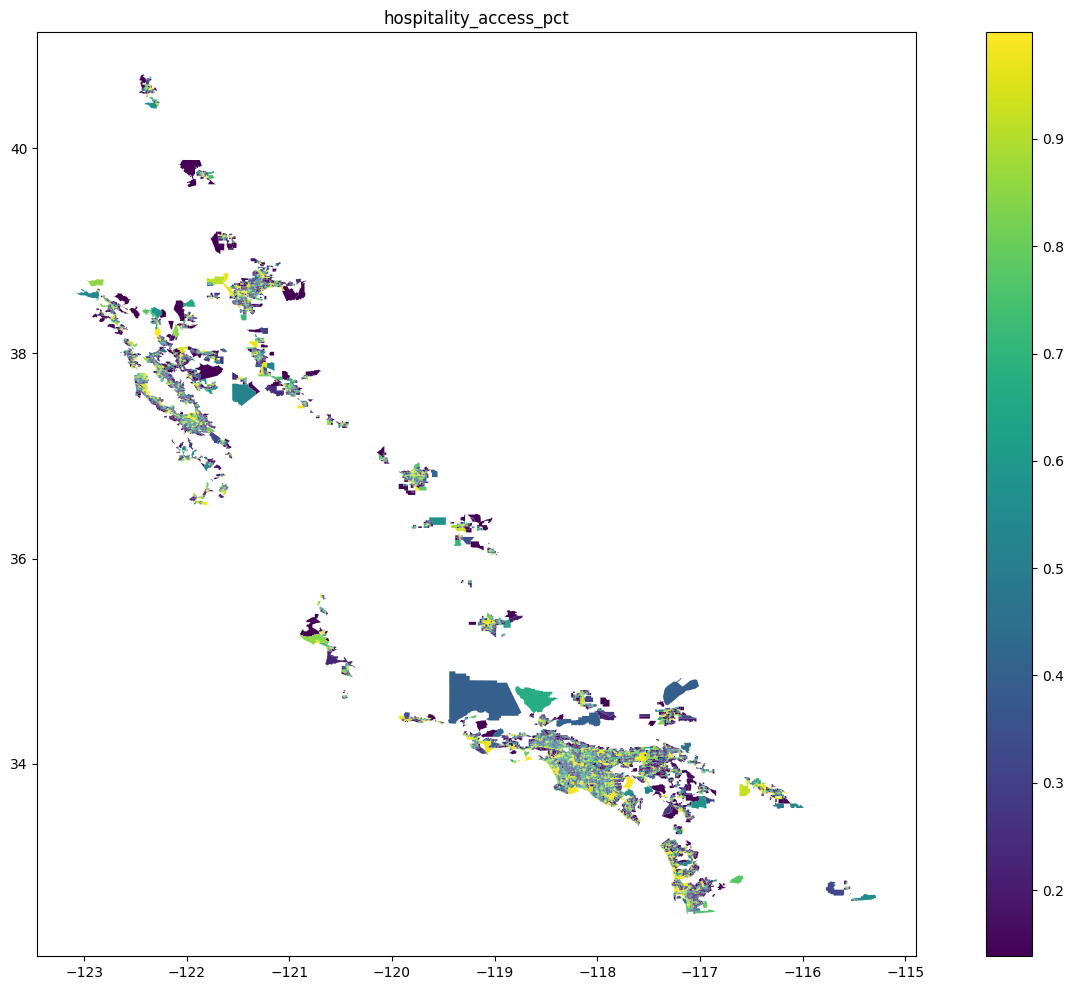

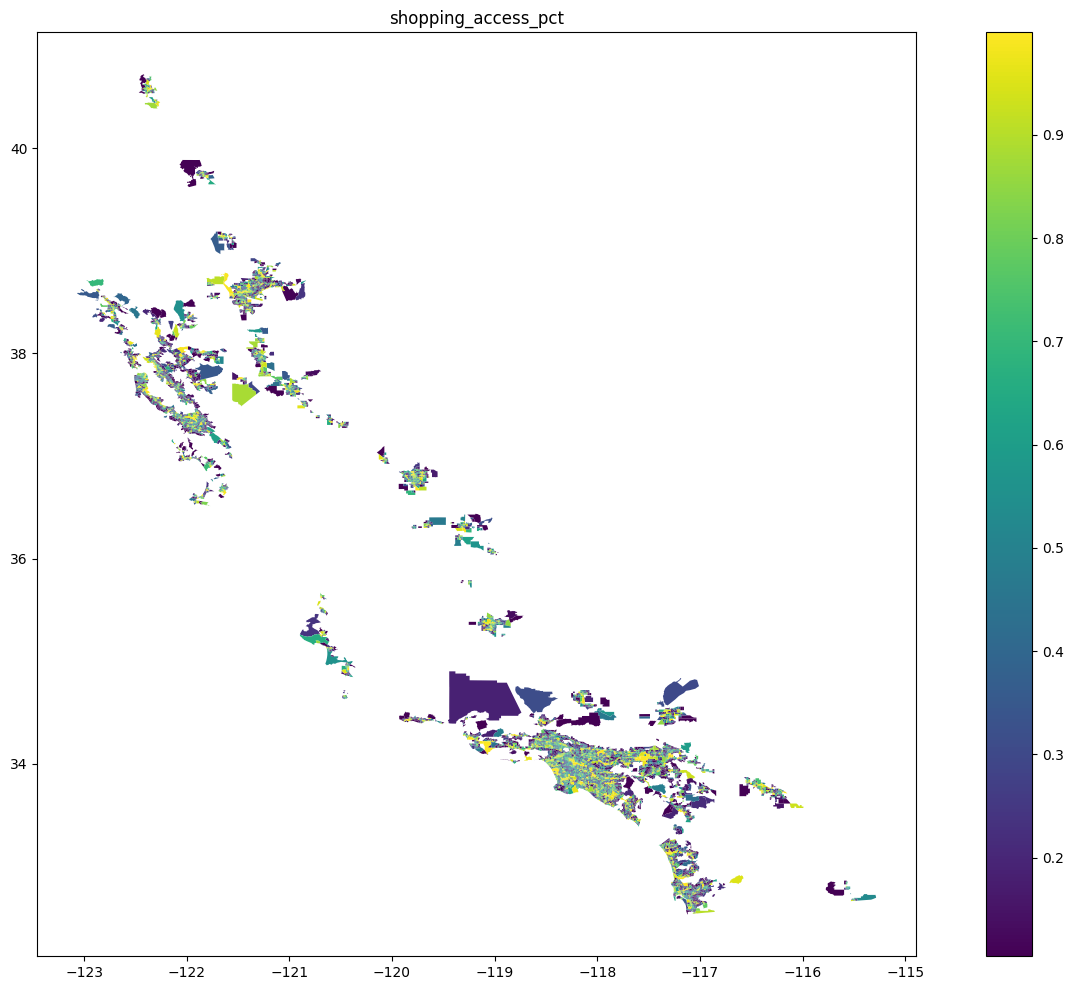

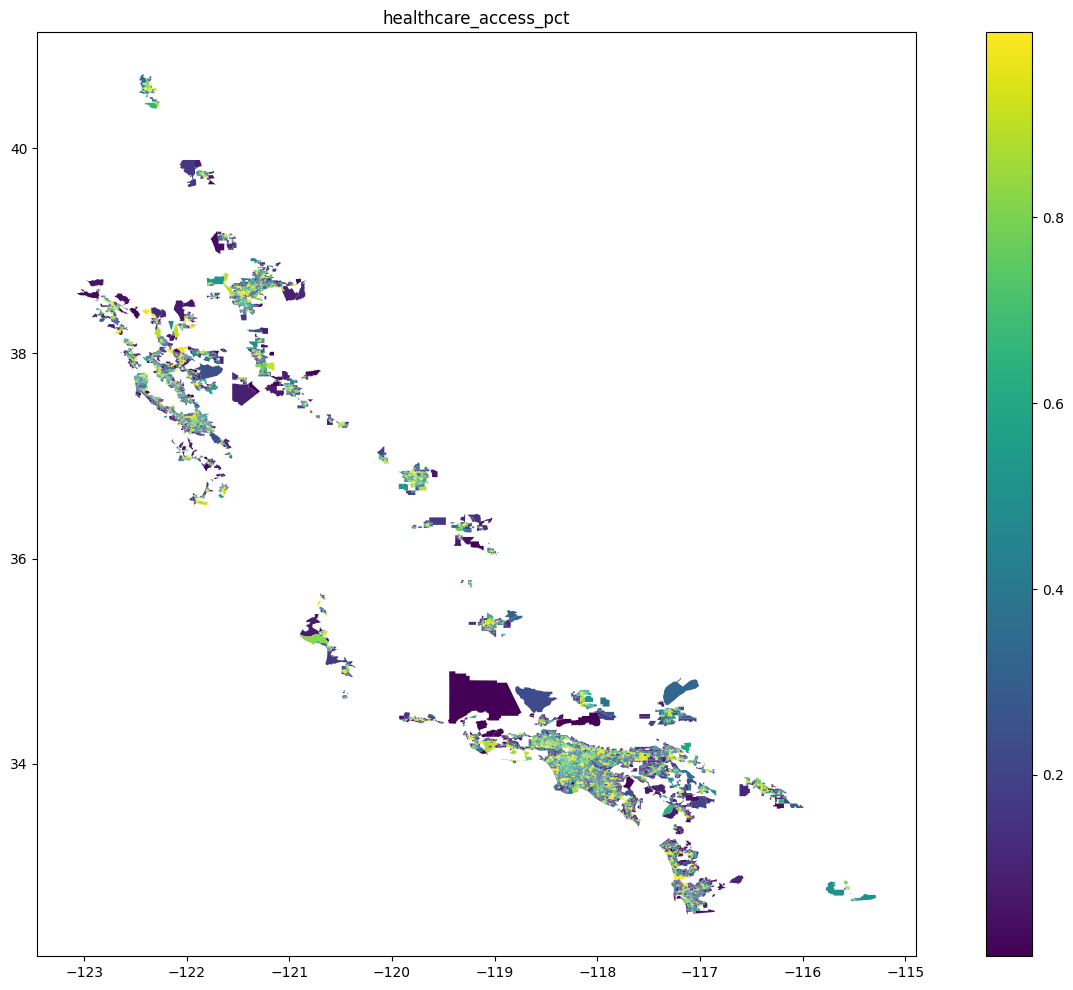

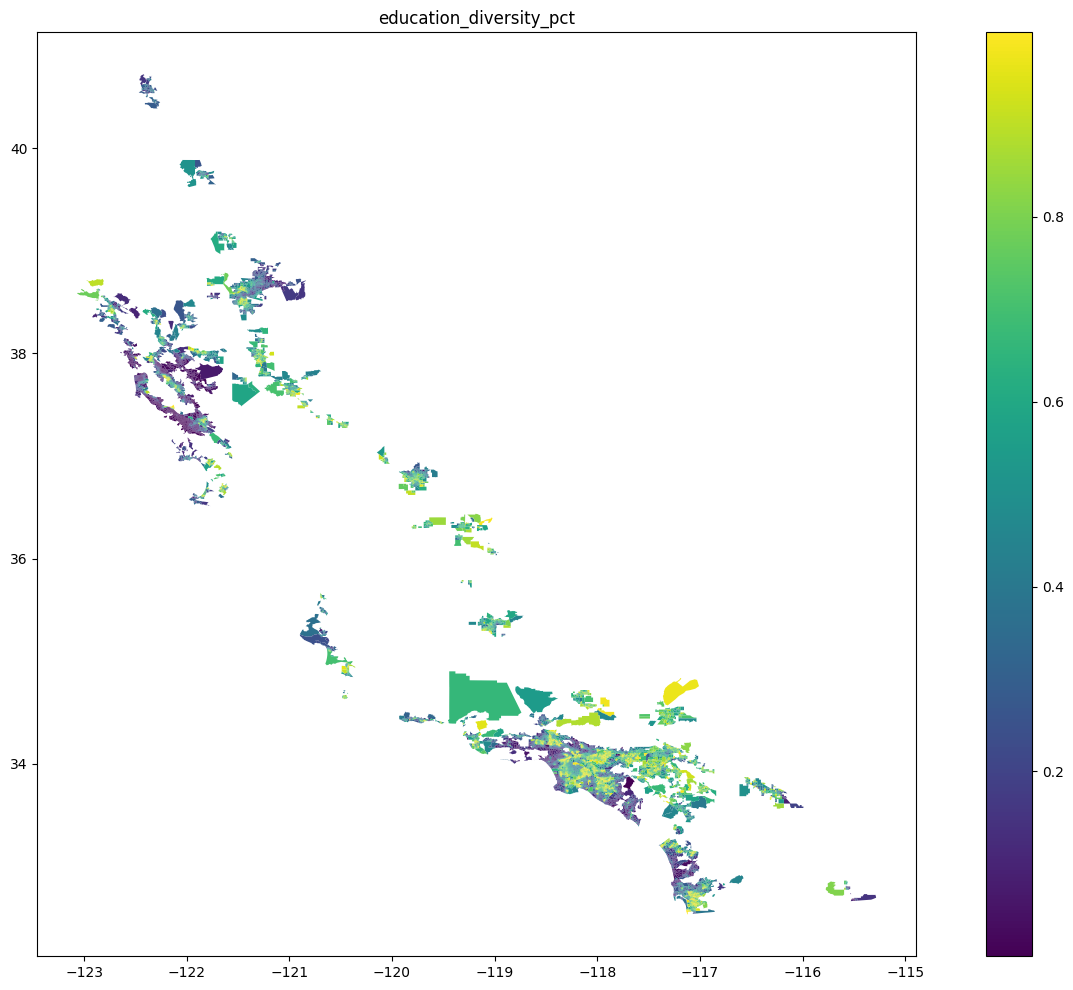

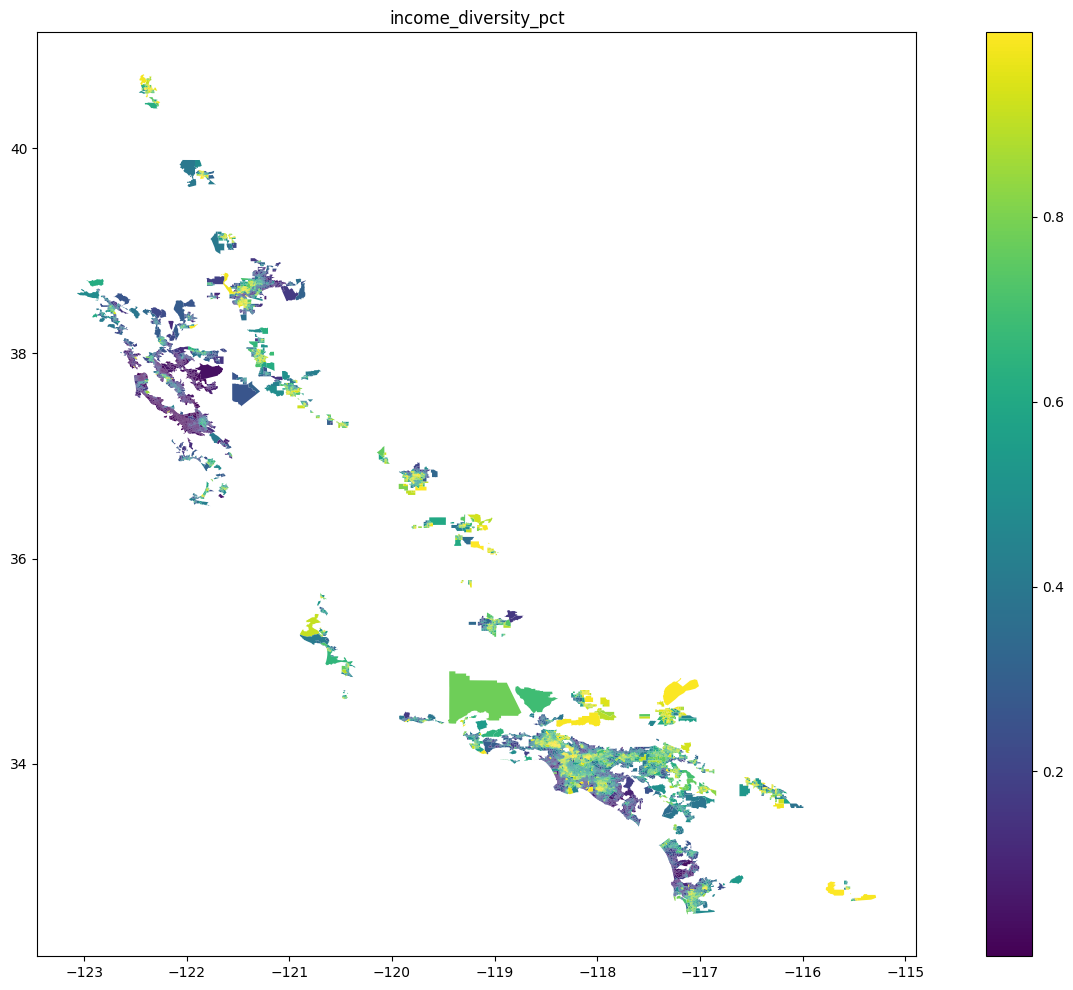

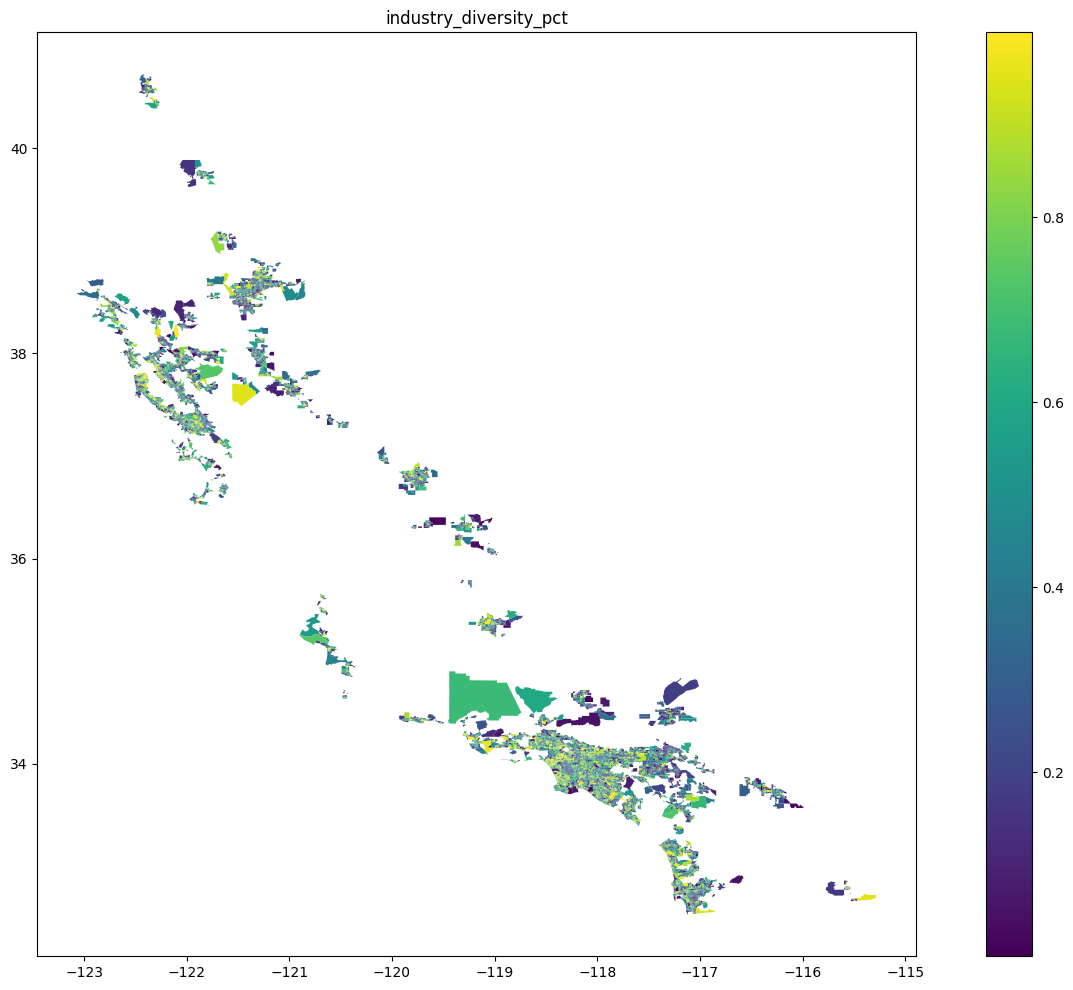

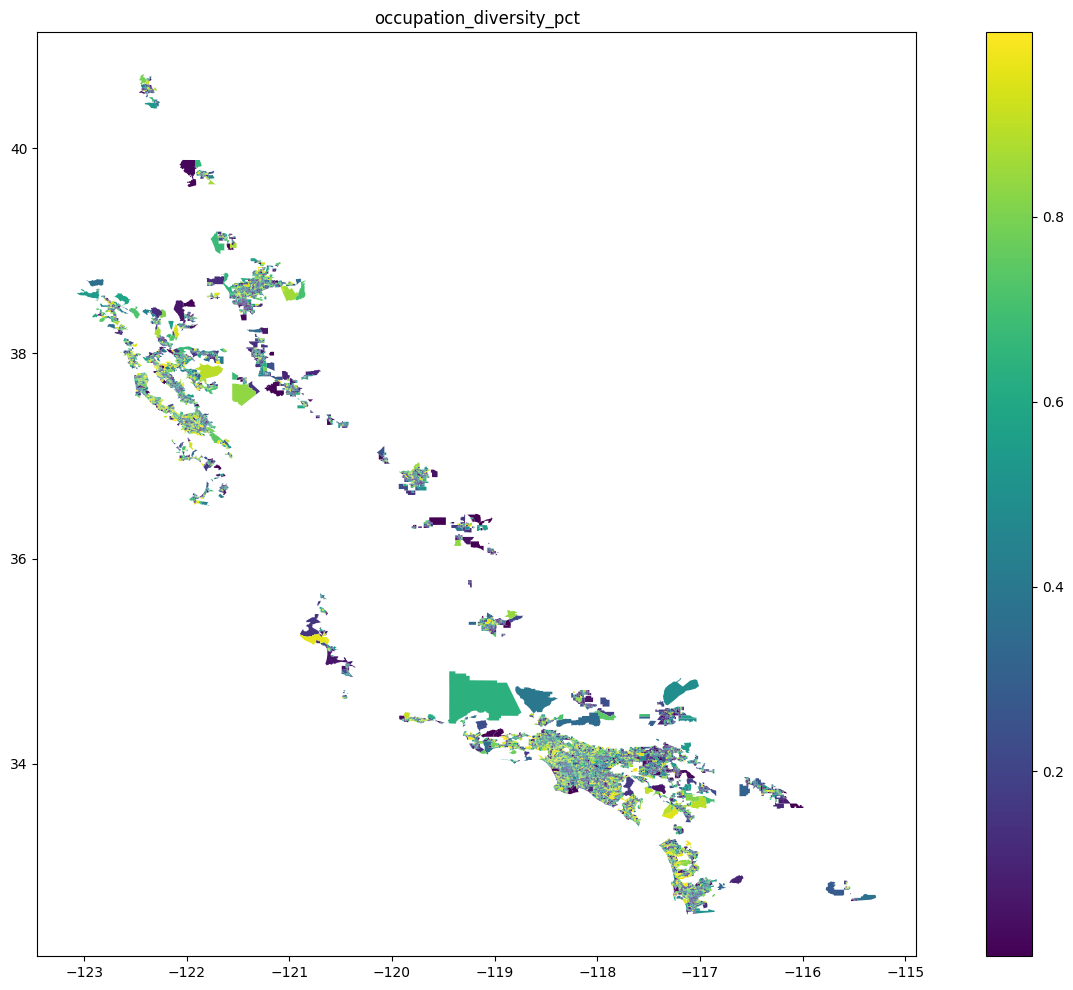

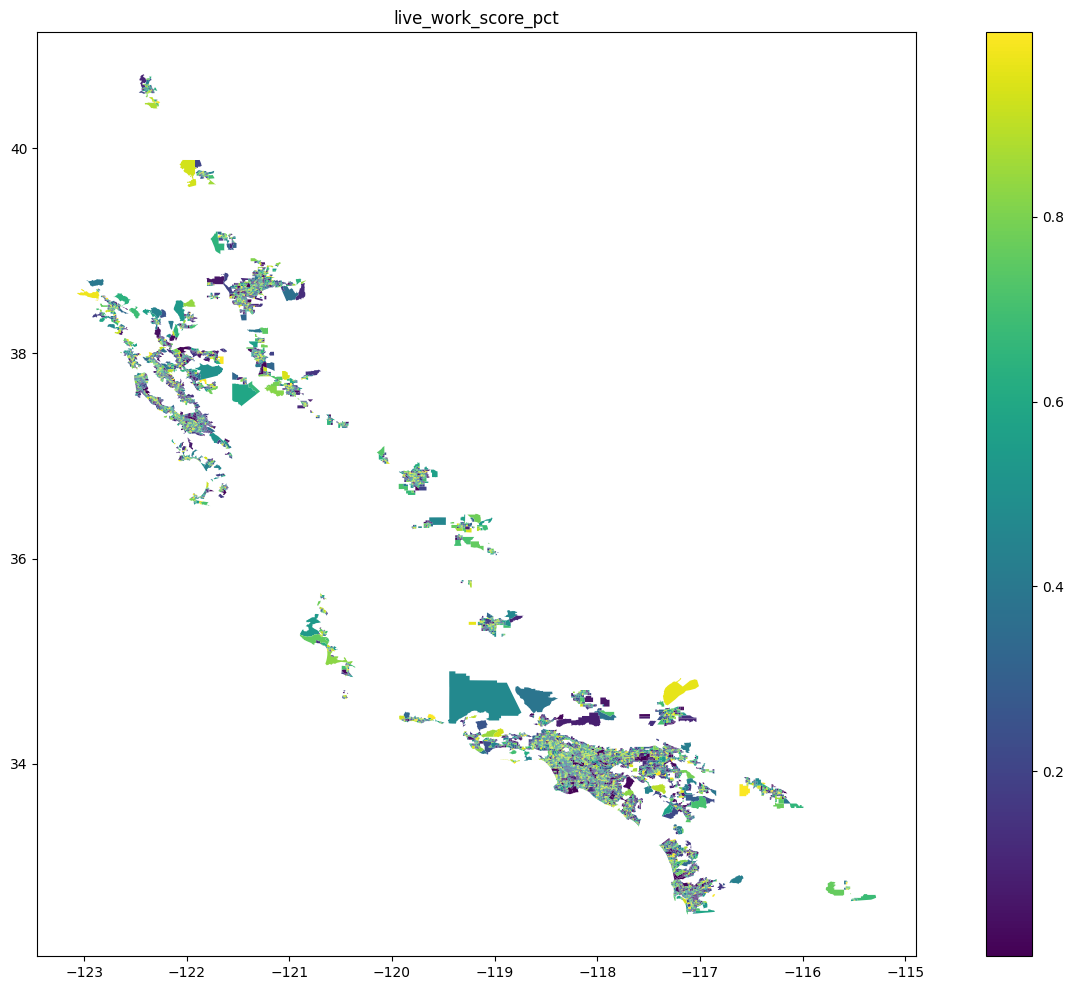

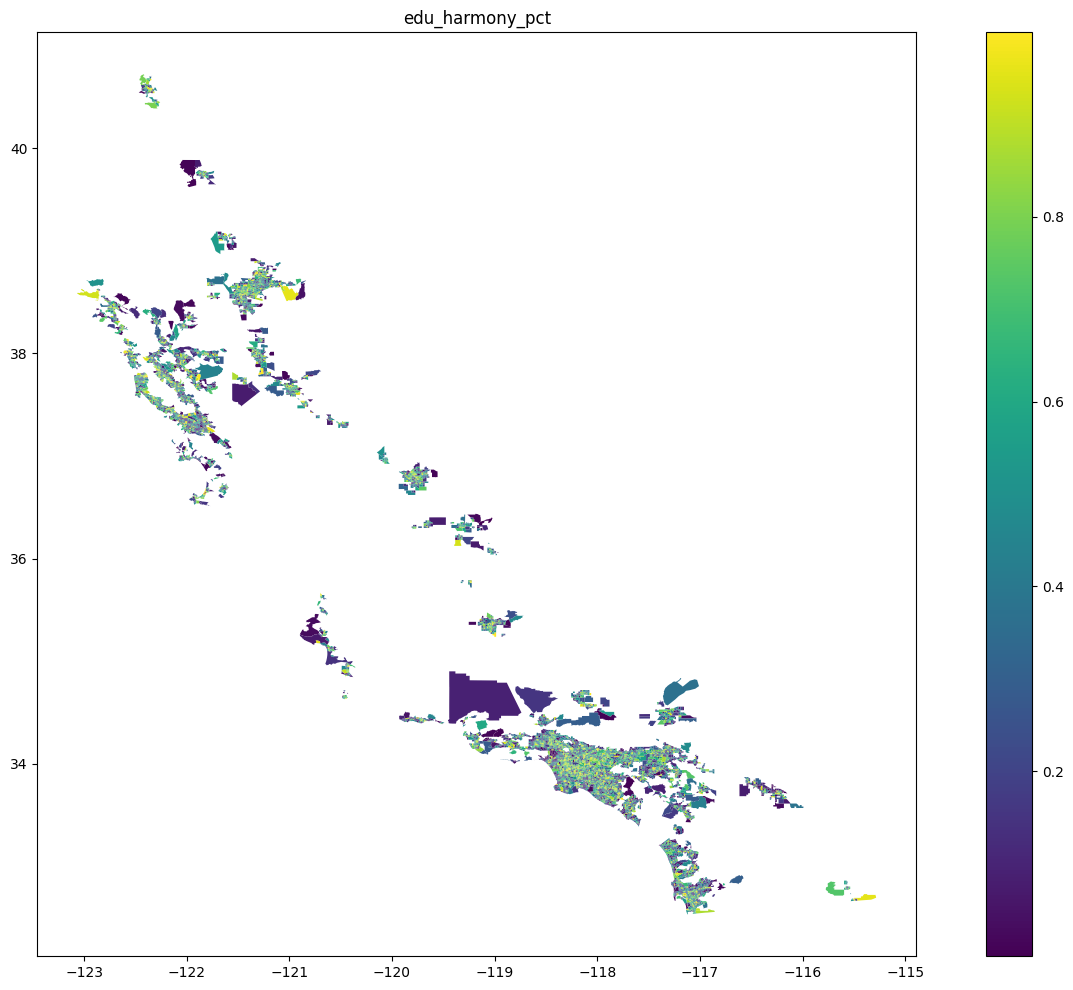

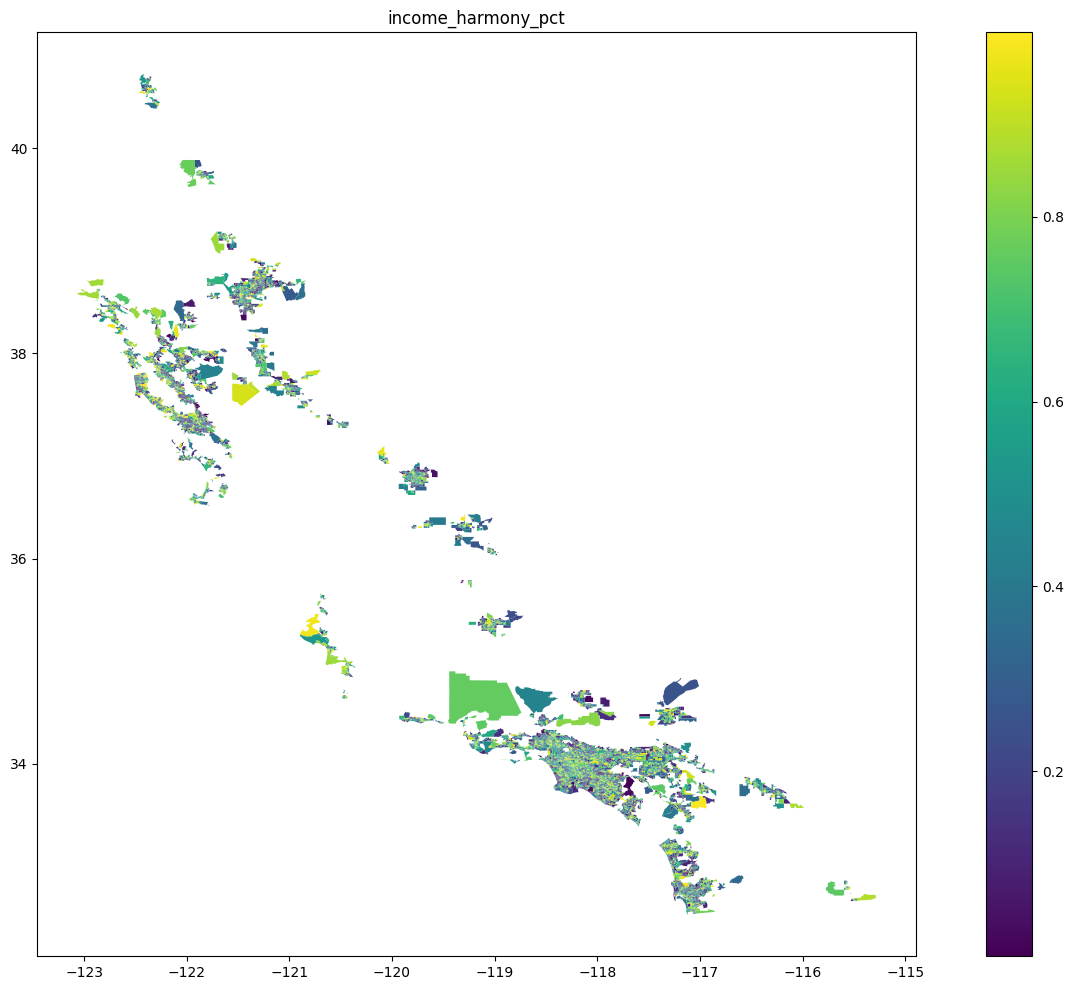

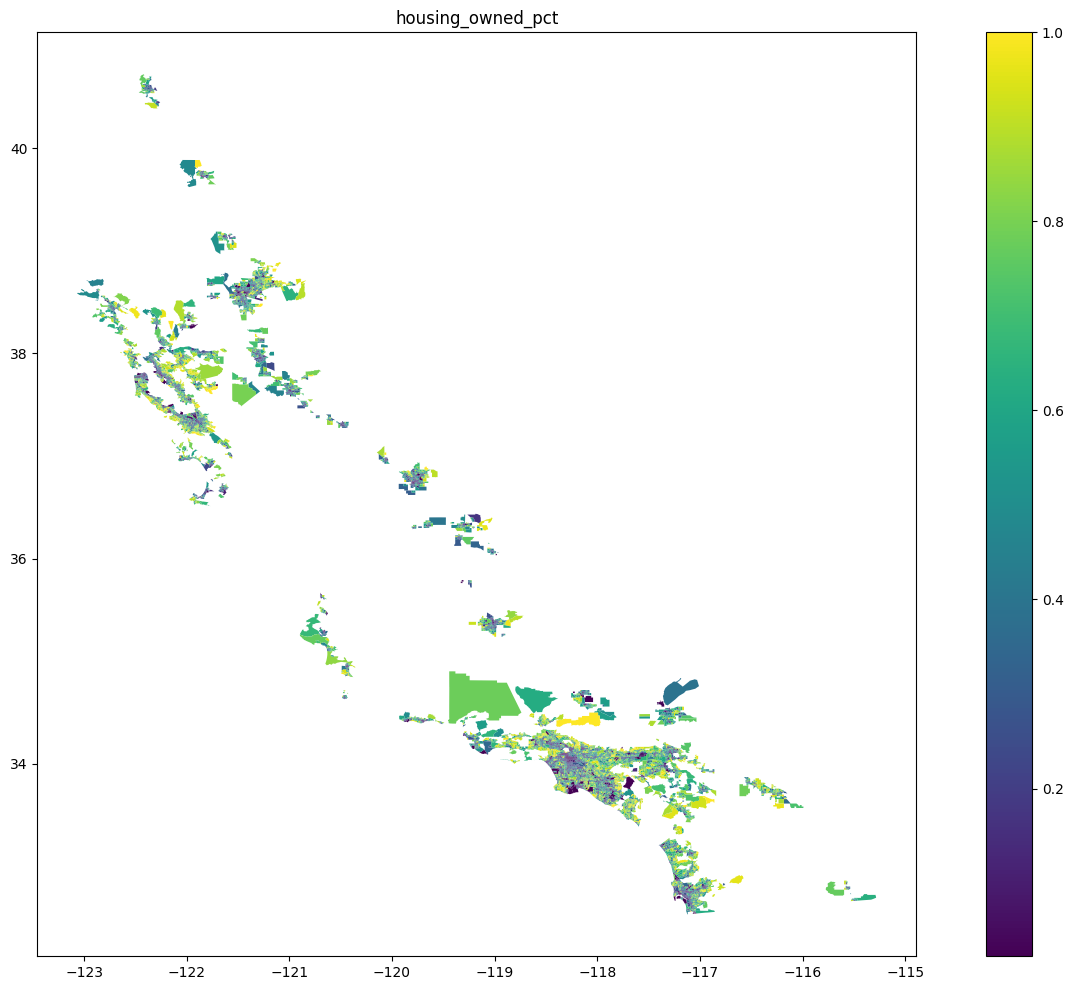

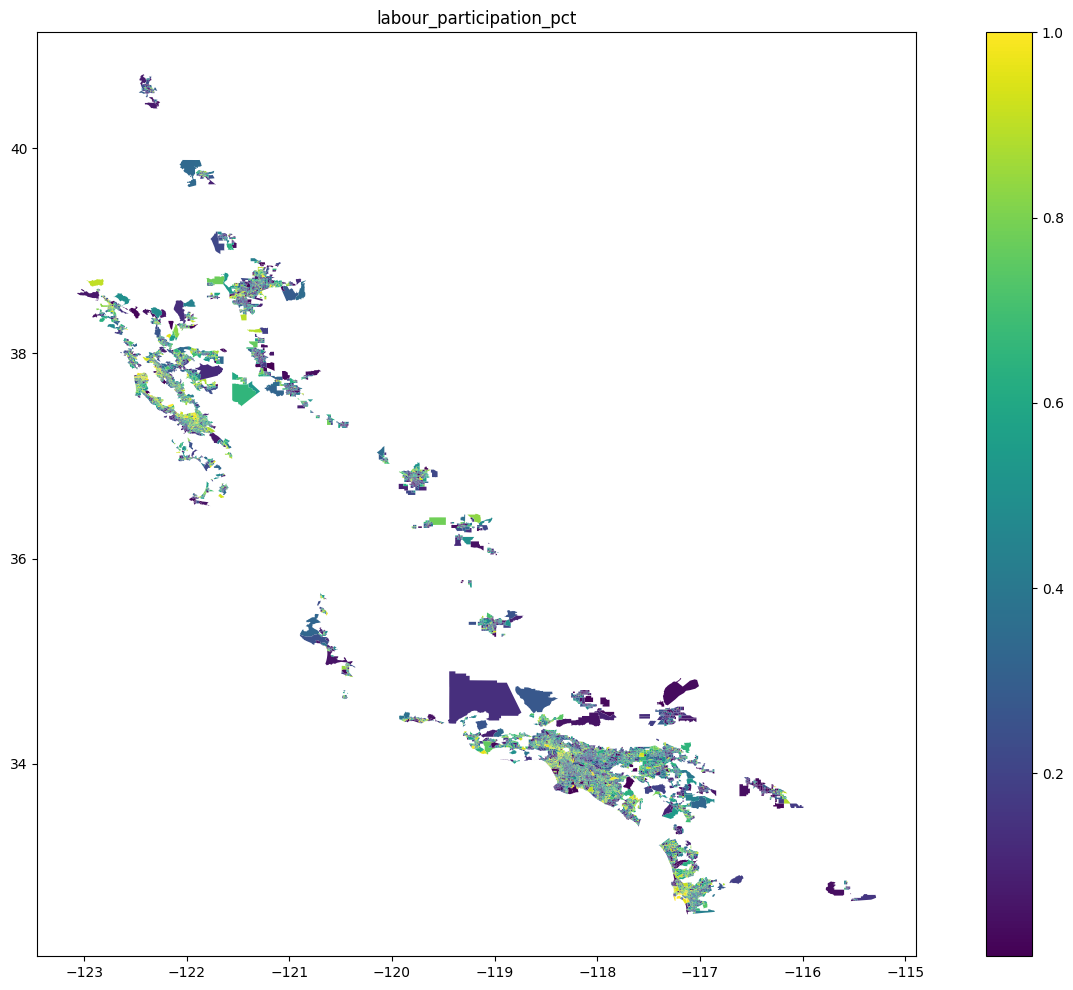

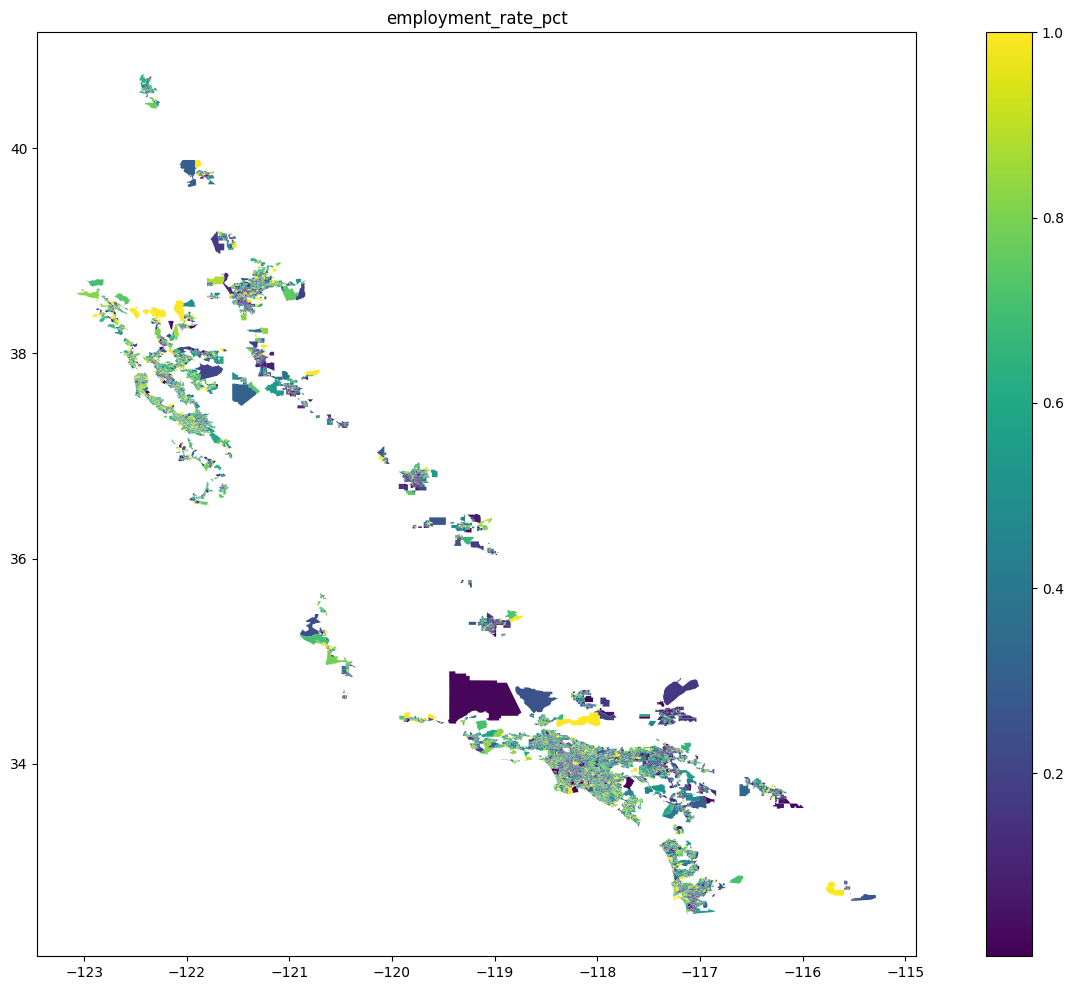

In [332]:
for score in all_raw_score_cols:
    col=score+'_pct'
    fig, ax=plt.subplots(1, figsize=(18,12))
    bg.plot(ax=ax,
            column=col,
            legend=True)
    ax.set_title(col)

# Final Grouped Scores

In [221]:
# for group in score_groups:
#     fig, ax=plt.subplots(1, figsize=(18,12))
#     bg.plot(ax=ax,
#             column=group,
#             legend=True)
#     ax.set_title(group)

In [333]:
all_final_scores= [
#     sg for sg in score_groups] + [
    score+'_pct' for score in all_raw_score_cols]

In [334]:
all_final_scores

['res_density_pct',
 'emp_density_pct',
 'jobs_access_pct',
 'hospitality_access_pct',
 'shopping_access_pct',
 'healthcare_access_pct',
 'education_diversity_pct',
 'income_diversity_pct',
 'industry_diversity_pct',
 'occupation_diversity_pct',
 'live_work_score_pct',
 'edu_harmony_pct',
 'income_harmony_pct',
 'housing_owned_pct',
 'labour_participation_pct',
 'employment_rate_pct']

In [344]:
save_cols=['geometry']+all_final_scores
# bg[save_cols].to_file('../outputs/metrics/{}/metrics_{}/metrics_{}.shp'.format(state_fips, state_fips, state_fips))
bg[save_cols].to_file('../outputs/{}/metrics_urbanized_{}.geojson'.format(state_fips, state_fips), 
                      driver='GeoJSON')

# Focussed Analysis

In [239]:
focus_bg='060816119002'

In [240]:
# occupations_df=pd.DataFrame(list(bg['worker_composition']))
skills_df=pd.DataFrame(list(bg['skills_composition']), index=bg.index)

In [241]:
skills_df.head()

,Active Learning,Active Listening,Complex Problem Solving,Coordination,Critical Thinking,Equipment Maintenance,Equipment Selection,Installation,Instructing,Judgment and Decision Making,...,Science,Service Orientation,Social Perceptiveness,Speaking,Systems Analysis,Systems Evaluation,Technology Design,Time Management,Troubleshooting,Writing
GEOID,,,,,,,,,,,,,,,,,,,,,
060378004081,9.900976,11.216340,9.487361,10.215333,10.802828,2.271642,2.870394,1.809965,9.348191,9.963246,...,5.570271,10.350537,10.702442,10.965733,7.947525,7.978625,3.642789,9.479222,4.380502,9.926549
060590014012,8.076246,9.321214,7.845749,8.473510,8.956907,2.365653,2.578755,1.777879,7.600114,8.198240,...,3.532368,8.360149,8.600623,9.136399,6.578354,6.541125,3.087379,7.961148,3.764245,8.138256
060372920001,9.189337,10.717132,9.077938,9.778503,10.404539,2.931345,3.100998,2.057171,8.413911,9.463191,...,4.352656,9.574720,9.873437,10.469964,7.444716,7.294442,3.516847,9.224575,4.549321,9.375515
060375702023,8.508079,9.853372,8.384379,8.923870,9.559466,2.887164,2.983218,2.031144,7.879355,8.688011,...,3.872821,8.673653,8.989036,9.648869,6.965033,6.843636,3.371588,8.493642,4.221989,8.689742
060374308013,8.711321,10.049840,8.574277,9.040512,9.748104,2.635114,2.869478,1.961073,7.991037,8.906728,...,3.926341,8.820391,9.083184,9.810495,7.283413,7.214355,3.482033,8.554972,4.138373,8.832859


In [242]:
skills_focus_bg=skills_df.loc[focus_bg]
skills_focus_bg

Active Learning                       8.964449
Active Listening                     10.099205
Complex Problem Solving               8.614399
Coordination                          9.090537
Critical Thinking                     9.744861
Equipment Maintenance                 2.211768
Equipment Selection                   2.660735
Installation                          1.726901
Instructing                           8.578470
Judgment and Decision Making          8.946831
Learning Strategies                   8.345140
Management of Financial Resources     4.126353
Management of Material Resources      4.645330
Management of Personnel Resources     7.278099
Mathematics                           6.733076
Monitoring                            9.449471
Negotiation                           7.505423
Operation Monitoring                  5.628960
Operation and Control                 4.125837
Operations Analysis                   4.515630
Persuasion                            7.961259
Programming  

<AxesSubplot:>

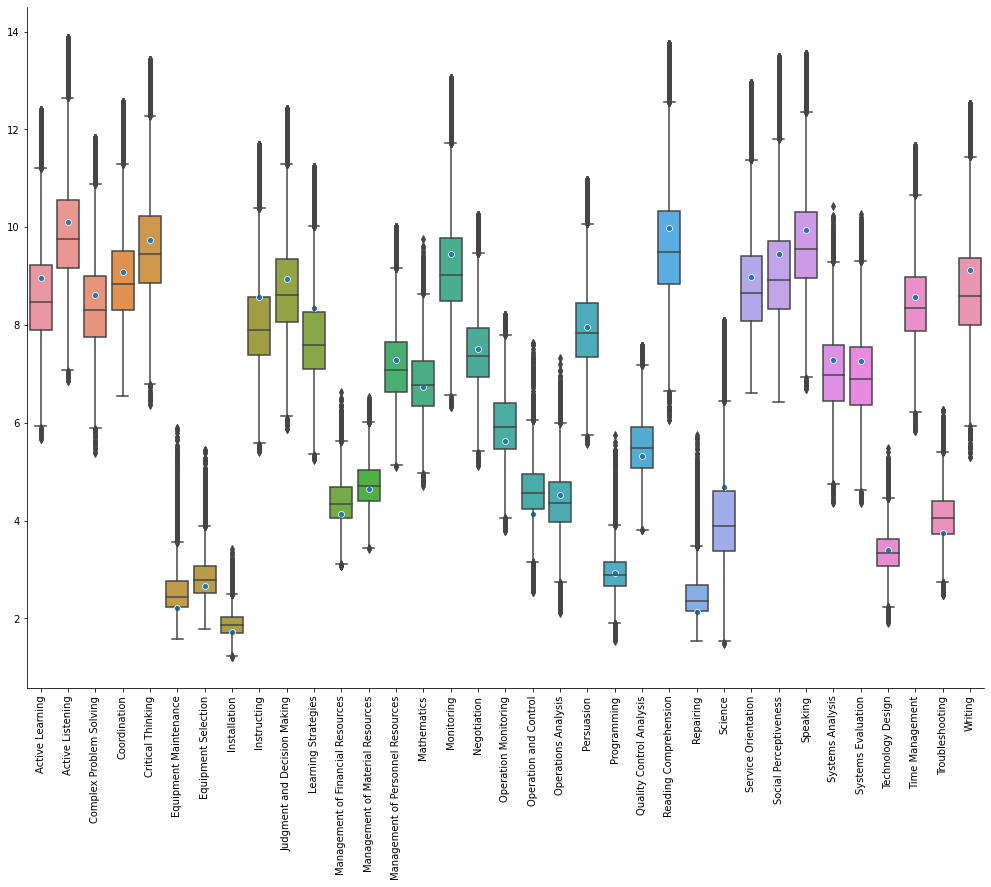

In [243]:
import seaborn as sns
ax = sns.catplot(data=skills_df, kind='box', height=10, aspect=1.4)
ax.set_xticklabels(rotation=90)
sns.scatterplot(range(len(skills_focus_bg)), skills_focus_bg.values, palette='bright')

In [244]:
for col in skills_df.columns:
    ecdf=ECDF(skills_df[col])
    skills_df[col+'_pct']=ecdf(skills_df[col])
    skills_df.loc[skills_df[col].isnull(), col+'_pct']=float('nan')

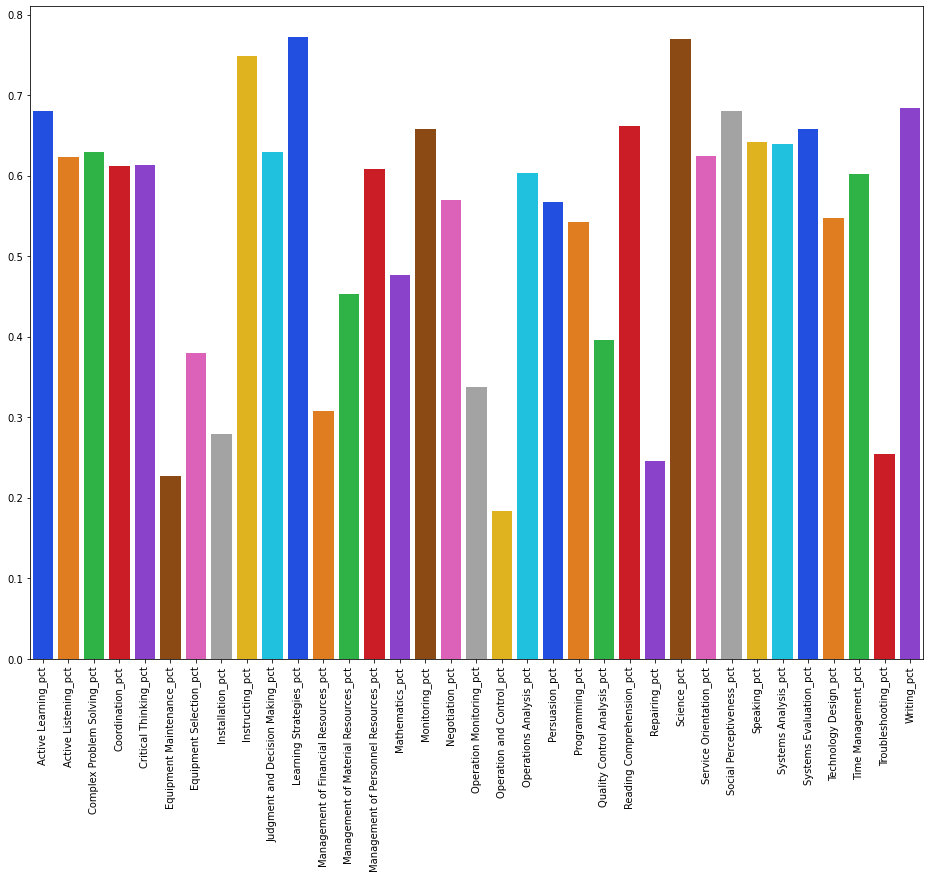

In [245]:
fig, ax = plt.subplots(figsize=(16, 12))

skills_pct_focus=skills_df.loc[focus_bg, [col for col in skills_df.columns if 'pct' in col]]
ax=sns.barplot(x=skills_pct_focus.keys(), y=skills_pct_focus.values, ax=ax, palette='bright')
_=ax.set_xticklabels(skills_pct_focus.keys(), rotation=90)

# Derivative each metric wrt each input

In [246]:
original_values=bg.loc[focus_bg].copy()
old_pct={col: all_ecdf[col](original_values[col]) for col in all_ecdf}

In [248]:
perturbed_columns={
 'emp_naics_11':'Agri Industry',
 'emp_naics_21':'Mining Industry',
 'emp_naics_22':'Utilities Industry',
 'emp_naics_23':'Construction Industry',
 'emp_naics_31-33':'Manufacturing Industry',
 'emp_naics_42':'Wholesale Industry',
 'emp_naics_44-45':'Retail Industry',
 'emp_naics_48-49':'Transportation Industry',
 'emp_naics_51':'Information JoIndustrybs',
 'emp_naics_52':'Finance Industry',
 'emp_naics_53':'Real Estate Industry',
 'emp_naics_54':'Scientific Industry',
 'emp_naics_55':'Management Industry',
 'emp_naics_56':'Administration Industry',
 'emp_naics_61':'Education Industry',
 'emp_naics_62':'Health Care Industry',
 'emp_naics_71':'Entertainment JobIndustrys',
 'emp_naics_72':'Accomodation Industry',
 'emp_naics_81':'Other Services Industry',
 'emp_naics_92':'Public Admin Industry',
 'res_income_1251-3333_rac':'Housing Med',
 'res_income_3333+_rac':'Housing Luxury',
 'res_income_u1250_rac':'Housing Affordable'
                  }

In [249]:
deltas={}
for p_col in perturbed_columns:
    new_values=original_values.copy()
    new_values[p_col]+=100
    if 'res_' in p_col:
        new_values['total_pop_rac']+=100
    elif 'emp_' in p_col:
        new_values['total_employ_wac']+=100
    new_values['live_work_score']=get_live_work_score(new_values)
    new_values['income_harmony']=get_income_harmony(new_values)
    new_values['edu_harmony']=get_edu_harmony(new_values)
    new_values=get_access_scores(new_values)
    new_values=get_skills_mix(new_values)
    new_values=get_diversity_scores(new_values)

    new_pct={col: all_ecdf[col](new_values[col]) for col in all_ecdf}
    diff={col: new_pct[col]-old_pct[col] for col in old_pct}
    deltas[p_col]=diff

In [250]:
deltas_df=pd.DataFrame(deltas).rename(columns=perturbed_columns)
deltas_df.index=[i.replace('_', ' ').title() for i in deltas_df.index]

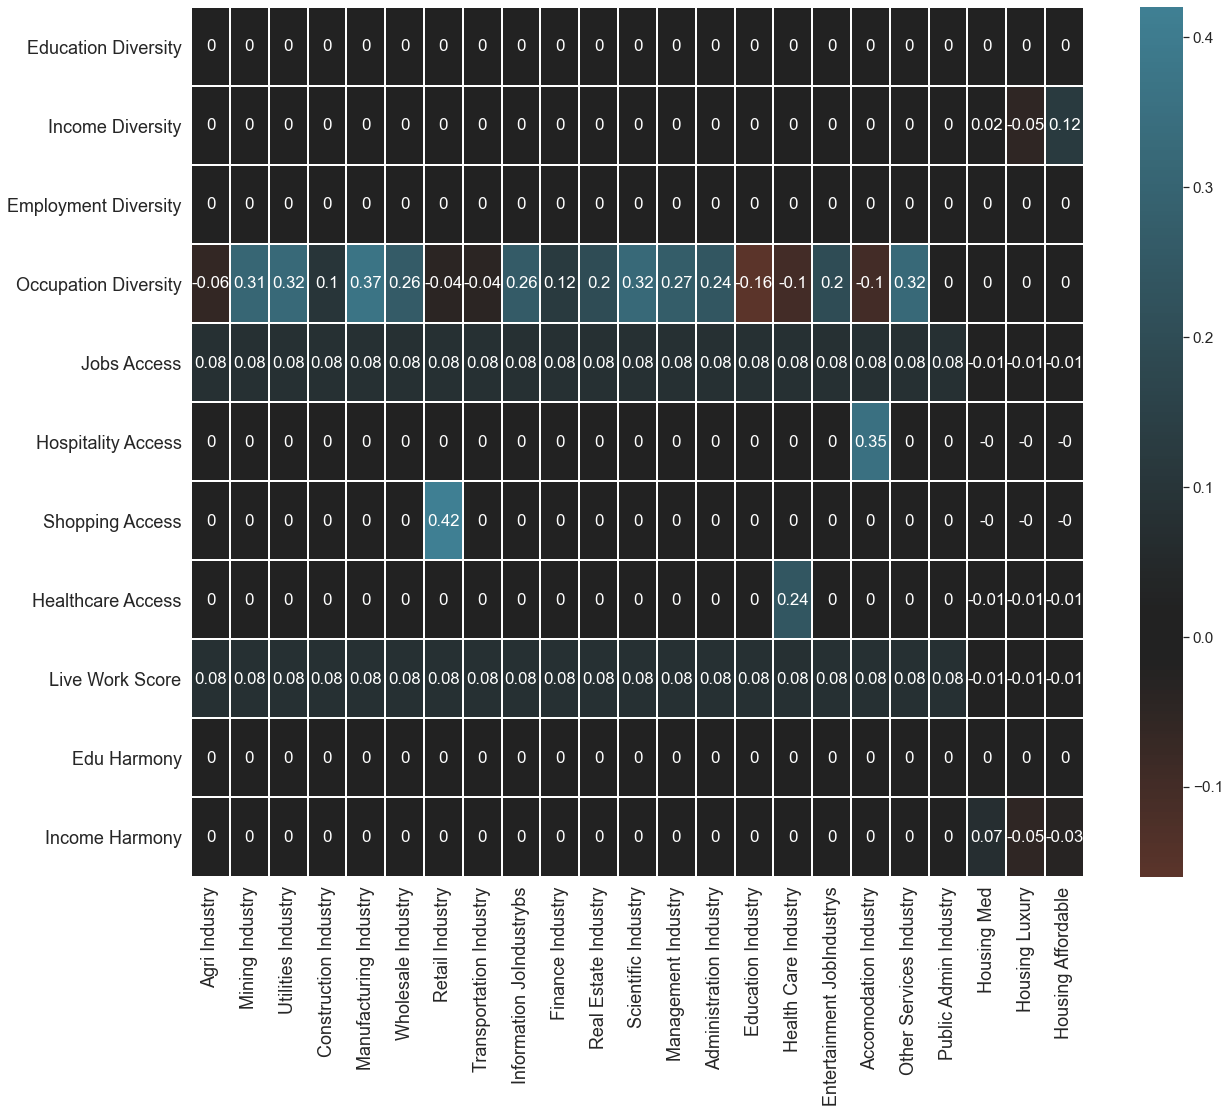

In [267]:
fig, ax = plt.subplots(figsize=(20, 16))
# sns.set(font_scale=1.4)
cmap=sns.diverging_palette(20, 220, center="dark",as_cmap=True)

ax=sns.heatmap(deltas_df.round(2), ax=ax, cmap=cmap, center=0, 
#             vmin=deltas_df.min().min(),vmax=deltas_df.max().max(), 
#             vmin=-1,vmax=1, 
            annot=True, linewidth=1, linecolor='w')
_=ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 18)
_=ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 18)